In [1]:
"""
PREDICTION LOOP:
Input: Classifier, Forecaster, Profiles, Label Encoders, Targets {Date,
                                                                  Period,
                                                                  Distribution,
                                                                  Price per volume,
                                                                  Price per volume without promo,
                                                                  Number of Categories,
                                                                  Number of Sub Categories,
                                                                  Category,
                                                                  Sub Category,
                                                                  Brand,
                                                                  }
Output: Predictions over 3Y + Sum over 3Y

"""

'\nPREDICTION LOOP:\nInput: Classifier, Forecaster, Profiles, Label Encoders, Targets {Date,\n                                                                  Period,\n                                                                  Distribution,\n                                                                  Price per volume,\n                                                                  Price per volume without promo,\n                                                                  Number of Categories,\n                                                                  Number of Sub Categories,\n                                                                  Category,\n                                                                  Sub Category,\n                                                                  Brand,\n                                                                  }\nOutput: Predictions over 3Y + Sum over 3Y\n\n'

In [41]:
import pickle
import json
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('whitegrid')

from prophet import Prophet
#import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
PATH_TO_INPUTS = 'assets/'

In [4]:
from sklearn.neighbors import NearestNeighbors

In [5]:
from datamanager.DM_USA import DM_USA

with open('assets/params.json', 'r') as f:
    json_sell_out_params = json.load(f)

data_manager=DM_USA()
data_manager.ad_hoc_USA(json_sell_out_params)
df = data_manager.get_df()

<open_excel> Loading data from file: data/Growth Modelling - USA - 2018-2021 - Sell-Out Data (IRI).xlsx
<fill_df> Size of Total Country dataframe : (575665, 14)


In [6]:
#set space for nn
df_temp = df.copy()

In [7]:
def build_train_set(df):
    df_temp = df.copy()
    df_temp = df_temp[["Category", "Sub Category", "Brand", "Distribution", "Price per volume", "Sales in volume"]]

    df_n_cat = df_temp.groupby(['Brand'])['Category'].agg(Number_of_Categories = "nunique").reset_index().rename(columns={'Number_of_Categories':'Number of Categories'})
    df_n_sub_cat = df_temp.groupby(['Brand', 'Category'])['Sub Category'].agg(Sub_Categories='nunique').reset_index().rename(columns={'Sub_Categories':'Number of Sub Categories'})

    df_temp = pd.merge(df_temp, df_n_cat, on="Brand", how="left")
    df_temp = pd.merge(df_temp, df_n_sub_cat, on=["Brand", 'Category'], how="left")

    df_sub = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Number of Categories', 'Number of Sub Categories'].max()

    """compute high level metrics for time series of Distribution and Price per volume : min, max, mean, std"""
    Distribution = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Distribution'].agg(
        {'min Distribution':'min', 'max Distribution':'max', 'mean Distribution':'mean', 'std Distribution':'std'}
    )

    Price = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Price per volume'].agg(
        {'min Price':'min', 'max Price':'max', 'mean Price':'mean', 'std Price':'std'}
    )

    """merge high level metrics into df_sub"""
    df_sub = pd.merge(df_sub, Distribution, on=['Category', 'Sub Category', 'Brand'])

    df_sub = pd.merge(df_sub, Price, on=['Category', 'Sub Category', 'Brand'])

    df_sub = df_sub.fillna(0.0)
    
    return df_sub

In [8]:
df_sub = build_train_set(df_temp)
df_sub_no_encoding = df_sub.copy()

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/1976902453.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sub = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Number of Categories', 'Number of Sub Categories'].max()


In [9]:
df_sub.columns

Index(['Category', 'Sub Category', 'Brand', 'Number of Categories',
       'Number of Sub Categories', 'min Distribution', 'max Distribution',
       'mean Distribution', 'std Distribution', 'min Price', 'max Price',
       'mean Price', 'std Price'],
      dtype='object')

In [10]:
le_cat = LabelEncoder()
df_sub['Category'] = le_cat.fit_transform(df_sub['Category'])
le_sub_cat = LabelEncoder()
df_sub['Sub Category'] = le_sub_cat.fit_transform(df_sub['Sub Category'])
le_brand = LabelEncoder()
df_sub['Brand'] = le_brand.fit_transform(df_sub['Brand'])

In [24]:
len(le_cat.classes_)

16

In [25]:
def build_profile(neighbors, df_sub, df, le_brand, le_cat, le_sub_cat):
    
    df_temp = df_sub.iloc[neighbors]
    df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
    df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
    df_temp['Brand'] = le_brand.inverse_transform(df_temp['Brand'])
    df_merge = pd.merge(df_temp[['Category', 'Sub Category', 'Brand']], df, on=['Category', 'Sub Category', 'Brand'], how='left')
    profile = df_merge.groupby('Date')['Sales in volume'].agg('mean')
    
    return profile



In [59]:
def forecast_profile(profile, target, periods=157, freq='W', plot=False):
    """ Forecasting profile using Prophet logistic growth giving the profile, 
    the targets for plotting useful information, and finally the periods and 
    freq of projection.

    """
    model_err = Prophet(growth='logistic', yearly_seasonality=20)
    
    # Adding Cap and Floor prediction 
    profile['cap'] = profile.y.max() * 2
    profile['floor'] = profile.y.mean() / 2
    model_err.fit(profile)

    err_forecast = model_err.predict()
    profile_err = profile.copy()
    
    profile_err.ds = pd.to_datetime(profile_err.ds)
    #profile_err = profile_err.rename(columns={"Date": "ds"})
    error_df = pd.merge(profile_err, err_forecast, on='ds')
    mape =  mean_absolute_percentage_error(error_df['y'], error_df['yhat'])
    
    model = Prophet(growth='logistic', yearly_seasonality=20)
    model.fit(profile)

    future = model.make_future_dataframe(periods=periods, freq=freq)
    future['cap'] = profile['cap'][0]
    future['floor'] = profile['floor'][0]
    
    # Predicting sales forecasts
    fcst = model.predict(future[future.ds > profile.ds.iloc[-1]])
    # Plot forecast
    if plot:
        fig = model.plot(fcst)
        ax = fig.gca()
        ax.set_title("{} => {}".format(target['Brand'], target['Category']))
        
    # dataset of columns ['ds', 'y'] to return, with correct historic values
    fcst = pd.concat([profile[['ds', 'y']], fcst[['ds', 'yhat']].rename(
        columns={'yhat': 'y'})])
    fcst['ds'] = pd.to_datetime(fcst['ds'], format='%Y-%m-%d')
    
    
        
    return fcst, mape

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.61629
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       403.699    0.00429033       79.8731   4.642e-05       0.001      128  LS failed, Hessian reset 
      90       403.884   6.29569e-05       62.7019   1.126e-06       0.001      195  LS failed, Hessian reset 
      99        403.89   2.31284e-05       31.7244      0.7619      0.7619      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       403.947   0.000220261       63.6533   2.523e-06       0.001      320  LS failed, Hessian reset 
     199       403.969   1.85074e-06       69.8732      0.2602           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       403.969   3.57972e-06       62.7516   3.837e-08       0.001      425  LS failed, Hessian reset 
     223       403.969   8.75837e-09       77.5494      0.1993   

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.61629
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       403.699    0.00429033       79.8731   4.642e-05       0.001      128  LS failed, Hessian reset 
      90       403.884   6.29569e-05       62.7019   1.126e-06       0.001      195  LS failed, Hessian reset 
      99        403.89   2.31284e-05       31.7244      0.7619      0.7619      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       403.947   0.000220261       63.6533   2.523e-06       0.001      320  LS failed, Hessian reset 
     199       403.969   1.85074e-06       69.8732      0.2602           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       403.969   3.57972e-06       62.7516   3.837e-08       0.001      425  LS failed, Hessian reset 
     223       403.969   8.75837e-09       77.5494      0.1993   

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.72137
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       443.063   7.35228e-06       89.5738      0.8926      0.8926      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       443.295    0.00123764       104.289   1.378e-05       0.001      217  LS failed, Hessian reset 
     162       443.388   6.79578e-06       48.1176   2.217e-07       0.001      282  LS failed, Hessian reset 
     199       443.414   3.64015e-05       61.3863      0.9193      0.9193      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       444.048    0.00264674       96.3614    2.59e-05       0.001      490  LS failed, Hessian reset 
     299       444.168   0.000581732       72.1706      0.4346      0.9465      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.72137
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       443.063   7.35228e-06       89.5738      0.8926      0.8926      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       443.295    0.00123764       104.289   1.378e-05       0.001      217  LS failed, Hessian reset 
     162       443.388   6.79578e-06       48.1176   2.217e-07       0.001      282  LS failed, Hessian reset 
     199       443.414   3.64015e-05       61.3863      0.9193      0.9193      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       444.048    0.00264674       96.3614    2.59e-05       0.001      490  LS failed, Hessian reset 
     299       444.168   0.000581732       72.1706      0.4346      0.9465      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -4.08447
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       401.766    0.00197757        96.675   2.507e-05       0.001      120  LS failed, Hessian reset 
      99       401.878   7.13443e-06        56.369      0.4956      0.4956      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       402.496    0.00345455       104.327   3.329e-05       0.001      304  LS failed, Hessian reset 
     199       402.768   0.000311817       85.0657           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       403.093   2.22966e-05       55.4392   4.148e-07       0.001      476  LS failed, Hessian reset 
     299       403.094   5.82521e-07       60.8616           1           1      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -4.08447
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       401.766    0.00197757        96.675   2.507e-05       0.001      120  LS failed, Hessian reset 
      99       401.878   7.13443e-06        56.369      0.4956      0.4956      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       402.496    0.00345455       104.327   3.329e-05       0.001      304  LS failed, Hessian reset 
     199       402.768   0.000311817       85.0657           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       403.093   2.22966e-05       55.4392   4.148e-07       0.001      476  LS failed, Hessian reset 
     299       403.094   5.82521e-07       60.8616           1           1      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -5.25443
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       407.606    0.00106123       90.8336   1.344e-05       0.001      159  LS failed, Hessian reset 
      99       407.681   0.000653906       57.0426      0.9304      0.9304      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       407.731   0.000107255       72.3216   1.299e-06       0.001      289  LS failed, Hessian reset 
     199       407.734   5.54417e-07       33.2868      0.4558      0.4558      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       407.737   4.07136e-05       103.817   6.104e-07       0.001      432  LS failed, Hessian reset 
     288       407.738   2.95562e-09       33.7912     0.08237     0.08237      507   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -5.25443
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       407.606    0.00106123       90.8336   1.344e-05       0.001      159  LS failed, Hessian reset 
      99       407.681   0.000653906       57.0426      0.9304      0.9304      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       407.731   0.000107255       72.3216   1.299e-06       0.001      289  LS failed, Hessian reset 
     199       407.734   5.54417e-07       33.2868      0.4558      0.4558      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       407.737   4.07136e-05       103.817   6.104e-07       0.001      432  LS failed, Hessian reset 
     288       407.738   2.95562e-09       33.7912     0.08237     0.08237      507   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.77419
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       442.198   7.70786e-05       77.6646           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       442.206   6.61488e-09       86.3814      0.1388      0.1388      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.77419
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       442.198   7.70786e-05       77.6646           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       442.206   6.61488e-09       86.3814      0.1388      0.1388      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -4.03974
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.029   2.55611e-05       58.1626      0.7781      0.7781      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       407.041   1.85021e-07       68.1606   2.269e-09       0.001      315  LS failed, Hessian reset 
     199       407.041   6.92457e-08       52.2805           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       407.041   2.15809e-08       51.4759      0.5785      0.5785      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -4.03974
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.029   2.55611e-05       58.1626      0.7781      0.7781      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       407.041   1.85021e-07       68.1606   2.269e-09       0.001      315  LS failed, Hessian reset 
     199       407.041   6.92457e-08       52.2805           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       407.041   2.15809e-08       51.4759      0.5785      0.5785      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -4.10257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       403.553    0.00347077       79.9623    4.34e-05       0.001      119  LS failed, Hessian reset 
      99       403.808   5.26387e-05       49.3073           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       403.826    3.8015e-05       68.4946   4.537e-07       0.001      248  LS failed, Hessian reset 
     192       403.827   6.55702e-07       74.4044   7.096e-09       0.001      356  LS failed, Hessian reset 
     199       403.827    1.2304e-07       64.7034           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       403.827   4.60142e-08       61.1334           1           1      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -4.10257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       403.553    0.00347077       79.9623    4.34e-05       0.001      119  LS failed, Hessian reset 
      99       403.808   5.26387e-05       49.3073           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       403.826    3.8015e-05       68.4946   4.537e-07       0.001      248  LS failed, Hessian reset 
     192       403.827   6.55702e-07       74.4044   7.096e-09       0.001      356  LS failed, Hessian reset 
     199       403.827    1.2304e-07       64.7034           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       403.827   4.60142e-08       61.1334           1           1      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.78798
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       400.258    0.00384539       75.8974   5.868e-05       0.001       96  LS failed, Hessian reset 
      99       400.517   0.000358875       91.9221     0.04454           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       400.794    0.00365055       53.3457   3.625e-05       0.001      248  LS failed, Hessian reset 
     199       400.956   0.000243316       77.1197           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       401.388    0.00301549       91.4854   3.616e-05       0.001      391  LS failed, Hessian reset 
     299       401.862   8.43967e-05       55.1338        2.83       0.283      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.78798
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       400.258    0.00384539       75.8974   5.868e-05       0.001       96  LS failed, Hessian reset 
      99       400.517   0.000358875       91.9221     0.04454           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       400.794    0.00365055       53.3457   3.625e-05       0.001      248  LS failed, Hessian reset 
     199       400.956   0.000243316       77.1197           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       401.388    0.00301549       91.4854   3.616e-05       0.001      391  LS failed, Hessian reset 
     299       401.862   8.43967e-05       55.1338        2.83       0.283      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -21.6531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95        458.65    0.00354514       97.2145   4.001e-05       0.001      154  LS failed, Hessian reset 
      99       458.832   0.000367075       80.8143      0.4302      0.4302      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       459.221   6.77686e-09       91.1139      0.2384      0.2384      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -21.6531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95        458.65    0.00354514       97.2145   4.001e-05       0.001      154  LS failed, Hessian reset 
      99       458.832   0.000367075       80.8143      0.4302      0.4302      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       459.221   6.77686e-09       91.1139      0.2384      0.2384      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.99028
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       406.776    0.00332966       89.8773   3.881e-05       0.001      136  LS failed, Hessian reset 
      99        406.92   4.92874e-05        81.062      0.6786      0.6786      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       406.926   8.97522e-06       64.9169    1.15e-07       0.001      235  LS failed, Hessian reset 
     160       406.927   1.40497e-05       85.2065   1.574e-07       0.001      323  LS failed, Hessian reset 
     189       406.929   3.92601e-06       63.1462   4.116e-08       0.001      404  LS failed, Hessian reset 
     199       406.929     1.699e-07       84.6625           1           1      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       406.931   2.69345e-05       101.705   4.006e-07   

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.99028
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       406.776    0.00332966       89.8773   3.881e-05       0.001      136  LS failed, Hessian reset 
      99        406.92   4.92874e-05        81.062      0.6786      0.6786      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       406.926   8.97522e-06       64.9169    1.15e-07       0.001      235  LS failed, Hessian reset 
     160       406.927   1.40497e-05       85.2065   1.574e-07       0.001      323  LS failed, Hessian reset 
     189       406.929   3.92601e-06       63.1462   4.116e-08       0.001      404  LS failed, Hessian reset 
     199       406.929     1.699e-07       84.6625           1           1      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       406.931   2.69345e-05       101.705   4.006e-07   

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.78399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       400.355    0.00402039        64.473   4.601e-05       0.001      103  LS failed, Hessian reset 
      78       400.536   0.000170045       40.1633   2.136e-06       0.001      180  LS failed, Hessian reset 
      99       400.544   1.03262e-05       56.8198           1           1      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       400.544   1.52662e-08       74.1739      0.8693      0.8693      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.78399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       400.355    0.00402039        64.473   4.601e-05       0.001      103  LS failed, Hessian reset 
      78       400.536   0.000170045       40.1633   2.136e-06       0.001      180  LS failed, Hessian reset 
      99       400.544   1.03262e-05       56.8198           1           1      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       400.544   1.52662e-08       74.1739      0.8693      0.8693      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.86929
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        399.73   0.000337342       76.0473           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       400.516        0.0046       96.5754   4.478e-05       0.001      294  LS failed, Hessian reset 
     199       400.805    0.00035599       76.3164      0.8128      0.8128      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       400.843   6.17607e-05       89.1529   7.917e-07       0.001      384  LS failed, Hessian reset 
     275       400.845    1.4629e-08       69.1032      0.2219           1      444   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.86929
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        399.73   0.000337342       76.0473           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       400.516        0.0046       96.5754   4.478e-05       0.001      294  LS failed, Hessian reset 
     199       400.805    0.00035599       76.3164      0.8128      0.8128      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       400.843   6.17607e-05       89.1529   7.917e-07       0.001      384  LS failed, Hessian reset 
     275       400.845    1.4629e-08       69.1032      0.2219           1      444   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -14.049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       444.618    0.00356761       94.7557      0.7652      0.7652      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       446.239     0.0150304       104.876   0.0001455       0.001      175  LS failed, Hessian reset 
     152       447.004   0.000102914       80.8623   1.217e-06       0.001      256  LS failed, Hessian reset 
     193       447.014   1.89576e-08       78.4532      0.5156      0.5156      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -14.049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       444.618    0.00356761       94.7557      0.7652      0.7652      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       446.239     0.0150304       104.876   0.0001455       0.001      175  LS failed, Hessian reset 
     152       447.004   0.000102914       80.8623   1.217e-06       0.001      256  LS failed, Hessian reset 
     193       447.014   1.89576e-08       78.4532      0.5156      0.5156      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -5.03392
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       414.583    0.00119445       84.5375   1.233e-05       0.001      144  LS failed, Hessian reset 
      99       414.651   2.44959e-05       70.3836      0.2332      0.2332      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       414.667   7.29037e-06       62.4791   8.814e-08       0.001      304  LS failed, Hessian reset 
     199       414.667   4.74565e-08       67.9598      0.2031           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       414.667   9.52884e-09       83.7587      0.3192      0.3192      342   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -5.03392
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       414.583    0.00119445       84.5375   1.233e-05       0.001      144  LS failed, Hessian reset 
      99       414.651   2.44959e-05       70.3836      0.2332      0.2332      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       414.667   7.29037e-06       62.4791   8.814e-08       0.001      304  LS failed, Hessian reset 
     199       414.667   4.74565e-08       67.9598      0.2031           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       414.667   9.52884e-09       83.7587      0.3192      0.3192      342   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -14.5637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       443.574     0.0184066       91.8534      0.3822      0.6917      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       444.717   7.27076e-09       83.3513      0.4407      0.4407      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -14.5637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       443.574     0.0184066       91.8534      0.3822      0.6917      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       444.717   7.27076e-09       83.3513      0.4407      0.4407      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.9314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       404.201    0.00236517       81.7437   2.803e-05       0.001      128  LS failed, Hessian reset 
      99       404.328   0.000228124       71.1502           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       404.385   0.000195204       78.2258   3.576e-06       0.001      240  LS failed, Hessian reset 
     199       404.436   9.75479e-05       61.0853           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       405.486   0.000160571       60.3137    2.14e-06       0.001      482  LS failed, Hessian reset 
     299       405.492   1.15365e-06       72.3775           1           1      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.9314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       404.201    0.00236517       81.7437   2.803e-05       0.001      128  LS failed, Hessian reset 
      99       404.328   0.000228124       71.1502           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       404.385   0.000195204       78.2258   3.576e-06       0.001      240  LS failed, Hessian reset 
     199       404.436   9.75479e-05       61.0853           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       405.486   0.000160571       60.3137    2.14e-06       0.001      482  LS failed, Hessian reset 
     299       405.492   1.15365e-06       72.3775           1           1      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.64846
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       393.008    0.00292183       90.4058   3.283e-05       0.001      112  LS failed, Hessian reset 
      99       393.592    0.00394038       94.9424      0.3644           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       394.146      0.004668       96.1929   4.485e-05       0.001      215  LS failed, Hessian reset 
     179       394.838    3.1771e-05       90.3767   3.354e-07       0.001      333  LS failed, Hessian reset 
     199       394.842   2.08024e-07        86.889      0.5689      0.5689      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       394.842    5.2599e-09       92.1628      0.1274      0.1274      394   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.64846
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       393.008    0.00292183       90.4058   3.283e-05       0.001      112  LS failed, Hessian reset 
      99       393.592    0.00394038       94.9424      0.3644           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       394.146      0.004668       96.1929   4.485e-05       0.001      215  LS failed, Hessian reset 
     179       394.838    3.1771e-05       90.3767   3.354e-07       0.001      333  LS failed, Hessian reset 
     199       394.842   2.08024e-07        86.889      0.5689      0.5689      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       394.842    5.2599e-09       92.1628      0.1274      0.1274      394   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -20.8487
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       409.192    0.00410318       101.483      0.5411      0.5411      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161        410.79   2.21757e-08       86.5946      0.2528           1      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -20.8487
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       409.192    0.00410318       101.483      0.5411      0.5411      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161        410.79   2.21757e-08       86.5946      0.2528           1      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -23.9445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.126   2.78326e-05       87.2186      0.3453      0.3453      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        390.22    0.00104993       88.0407   1.071e-05       0.001      174  LS failed, Hessian reset 
     160       390.309   8.52304e-06       87.7458   9.663e-08       0.001      277  LS failed, Hessian reset 
     199        390.31   2.86252e-07       89.3961      0.9139      0.9139      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225        390.31   8.40343e-09       84.3076      0.2006      0.2006      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -23.9445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.126   2.78326e-05       87.2186      0.3453      0.3453      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        390.22    0.00104993       88.0407   1.071e-05       0.001      174  LS failed, Hessian reset 
     160       390.309   8.52304e-06       87.7458   9.663e-08       0.001      277  LS failed, Hessian reset 
     199        390.31   2.86252e-07       89.3961      0.9139      0.9139      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225        390.31   8.40343e-09       84.3076      0.2006      0.2006      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -23.6804
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       400.049     0.0181891       81.2156      0.1348           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       400.214    0.00435641        102.95   5.364e-05       0.001      154  LS failed, Hessian reset 
     196       401.799   1.08009e-08       79.1509      0.5846      0.5846      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -23.6804
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       400.049     0.0181891       81.2156      0.1348           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       400.214    0.00435641        102.95   5.364e-05       0.001      154  LS failed, Hessian reset 
     196       401.799   1.08009e-08       79.1509      0.5846      0.5846      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -19.5748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       412.468     0.0173367       98.6361   0.0001915       0.001      104  LS failed, Hessian reset 
      99       414.083    0.00898494       87.6544           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       414.582     0.0046726        55.045   5.758e-05       0.001      198  LS failed, Hessian reset 
     169       415.555     0.0005953       88.2908   6.724e-06       0.001      311  LS failed, Hessian reset 
     199       415.604   2.17026e-05        79.272           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       415.729   6.66108e-09       70.7451      0.2966      0.2966      454   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -19.5748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       412.468     0.0173367       98.6361   0.0001915       0.001      104  LS failed, Hessian reset 
      99       414.083    0.00898494       87.6544           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       414.582     0.0046726        55.045   5.758e-05       0.001      198  LS failed, Hessian reset 
     169       415.555     0.0005953       88.2908   6.724e-06       0.001      311  LS failed, Hessian reset 
     199       415.604   2.17026e-05        79.272           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       415.729   6.66108e-09       70.7451      0.2966      0.2966      454   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Initial log joint probability = -19.21
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       365.882    0.00600976       100.809   6.259e-05       0.001      147  LS failed, Hessian reset 
      99       366.478   0.000599782       80.4432      0.4619      0.4619      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       366.575   3.41725e-05        79.878   4.668e-07       0.001      240  LS failed, Hessian reset 
     189       366.578   3.24504e-09       69.2103     0.03181           1      317   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -19.21
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       365.882    0.00600976       100.809   6.259e-05       0.001      147  LS failed, Hessian reset 
      99       366.478   0.000599782       80.4432      0.4619      0.4619      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       366.575   3.41725e-05        79.878   4.668e-07       0.001      240  LS failed, Hessian reset 
     189       366.578   3.24504e-09       69.2103     0.03181           1      317   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -23.7162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       401.966     0.0153904       89.3079           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       407.207   5.78588e-07       82.8146      0.5394      0.5394      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       407.207   1.64812e-08       77.4175      0.2571           1      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -23.7162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       401.966     0.0153904       89.3079           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       407.207   5.78588e-07       82.8146      0.5394      0.5394      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       407.207   1.64812e-08       77.4175      0.2571           1      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -24.1531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       398.908     0.0020993       82.8626      0.8775      0.8775      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       399.454    0.00117639       77.0415   1.149e-05       0.001      223  LS failed, Hessian reset 
     191       399.589   6.22601e-05       88.8144   7.362e-07       0.001      326  LS failed, Hessian reset 
     199       399.593   5.66713e-06       85.5402           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       399.593   8.31007e-09       85.0825      0.1894      0.1894      374   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -24.1531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       398.908     0.0020993       82.8626      0.8775      0.8775      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       399.454    0.00117639       77.0415   1.149e-05       0.001      223  LS failed, Hessian reset 
     191       399.589   6.22601e-05       88.8144   7.362e-07       0.001      326  LS failed, Hessian reset 
     199       399.593   5.66713e-06       85.5402           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       399.593   8.31007e-09       85.0825      0.1894      0.1894      374   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -14.7957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       487.346     0.0237768        102.99           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       491.773    0.00509459       99.1865   6.927e-05       0.001      227  LS failed, Hessian reset 
     183       492.033   8.97552e-05       86.4391   1.245e-06       0.001      318  LS failed, Hessian reset 
     199       492.037   1.62165e-06        47.838      0.5816      0.5816      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       492.039   1.36148e-05       76.3082   1.576e-07       0.001      435  LS failed, Hessian reset 
     270        492.04    1.8942e-09       49.5065     0.01699           1      478   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -14.7957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       487.346     0.0237768        102.99           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       491.773    0.00509459       99.1865   6.927e-05       0.001      227  LS failed, Hessian reset 
     183       492.033   8.97552e-05       86.4391   1.245e-06       0.001      318  LS failed, Hessian reset 
     199       492.037   1.62165e-06        47.838      0.5816      0.5816      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       492.039   1.36148e-05       76.3082   1.576e-07       0.001      435  LS failed, Hessian reset 
     270        492.04    1.8942e-09       49.5065     0.01699           1      478   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -23.7906
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       399.443     0.0271193       91.7405           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       407.335   3.83825e-06       96.0208      0.6086      0.6086      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       407.521   0.000545074       89.4199   6.836e-06       0.001      422  LS failed, Hessian reset 
     299       407.582   1.28123e-05       77.5783           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       407.605   2.92342e-08       82.5138       0.323       0.323      544   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -23.7906
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       399.443     0.0271193       91.7405           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       407.335   3.83825e-06       96.0208      0.6086      0.6086      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       407.521   0.000545074       89.4199   6.836e-06       0.001      422  LS failed, Hessian reset 
     299       407.582   1.28123e-05       77.5783           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       407.605   2.92342e-08       82.5138       0.323       0.323      544   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -24.3779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       395.381     0.0446108       95.5131      0.9797      0.9797      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       400.605     0.0116642       80.5775   0.0001627       0.001      203  LS failed, Hessian reset 
     199       401.141   3.40351e-07       69.2151      0.5566      0.5566      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       401.141   5.43751e-09       68.6889     0.05476     0.05476      295   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -24.3779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       395.381     0.0446108       95.5131      0.9797      0.9797      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       400.605     0.0116642       80.5775   0.0001627       0.001      203  LS failed, Hessian reset 
     199       401.141   3.40351e-07       69.2151      0.5566      0.5566      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       401.141   5.43751e-09       68.6889     0.05476     0.05476      295   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -24.117
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       393.948    0.00543103       73.8555      0.1915           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       396.158     0.0126993       90.9478   0.0001705       0.001      180  LS failed, Hessian reset 
     173       396.745   4.75418e-07       72.1592    5.61e-09       0.001      304  LS failed, Hessian reset 
     184       396.745   4.95445e-09       68.9419      0.2366      0.2366      319   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -24.117
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       393.948    0.00543103       73.8555      0.1915           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       396.158     0.0126993       90.9478   0.0001705       0.001      180  LS failed, Hessian reset 
     173       396.745   4.75418e-07       72.1592    5.61e-09       0.001      304  LS failed, Hessian reset 
     184       396.745   4.95445e-09       68.9419      0.2366      0.2366      319   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -15.1638
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       465.365     0.0134513       113.489       0.618       0.618      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       472.432   0.000118714       114.513   1.253e-06       0.001      266  LS failed, Hessian reset 
     199       472.443   1.18497e-05       73.5859       0.482       0.482      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       472.445   1.50224e-07       99.2616   1.619e-09       0.001      376  LS failed, Hessian reset 
     255       472.445   2.56923e-08       77.1416      0.2386           1      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -15.1638
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       465.365     0.0134513       113.489       0.618       0.618      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       472.432   0.000118714       114.513   1.253e-06       0.001      266  LS failed, Hessian reset 
     199       472.443   1.18497e-05       73.5859       0.482       0.482      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       472.445   1.50224e-07       99.2616   1.619e-09       0.001      376  LS failed, Hessian reset 
     255       472.445   2.56923e-08       77.1416      0.2386           1      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -22.589
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       404.089     0.0156278       97.9363           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       408.333   0.000686872       84.8894   8.367e-06       0.001      230  LS failed, Hessian reset 
     199       408.441   9.26187e-07       74.1349      0.1582      0.5312      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       408.442   5.69467e-06       79.4915    6.64e-08       0.001      364  LS failed, Hessian reset 
     291       408.443   1.46135e-07       74.8105   1.716e-09       0.001      488  LS failed, Hessian reset 
     298       408.443   7.35829e-09       72.3562      0.2136           1      499   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was b

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -22.589
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       404.089     0.0156278       97.9363           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       408.333   0.000686872       84.8894   8.367e-06       0.001      230  LS failed, Hessian reset 
     199       408.441   9.26187e-07       74.1349      0.1582      0.5312      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       408.442   5.69467e-06       79.4915    6.64e-08       0.001      364  LS failed, Hessian reset 
     291       408.443   1.46135e-07       74.8105   1.716e-09       0.001      488  LS failed, Hessian reset 
     298       408.443   7.35829e-09       72.3562      0.2136           1      499   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was b

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -15.0529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.107     0.0149326       101.723           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       474.277   0.000238779        93.919      0.5728      0.9782      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       474.657   2.34924e-05       106.121           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       478.302    0.00454508       91.1584      0.6652      0.6652      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     476       480.124   2.29687e-08       97.1784      0.2403           1      576   
Optimization terminated normally: 
  Convergence detected: relat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -15.0529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.107     0.0149326       101.723           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       474.277   0.000238779        93.919      0.5728      0.9782      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       474.657   2.34924e-05       106.121           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       478.302    0.00454508       91.1584      0.6652      0.6652      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     476       480.124   2.29687e-08       97.1784      0.2403           1      576   
Optimization terminated normally: 
  Convergence detected: relat

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -23.5826
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       399.536     0.0149688       80.6223           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       403.947   5.42504e-06       66.4499       0.387           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       403.948   1.08794e-08       83.7978      0.3809           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -23.5826
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       399.536     0.0149688       80.6223           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       403.947   5.42504e-06       66.4499       0.387           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       403.948   1.08794e-08       83.7978      0.3809           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -19.2237
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73        396.69    0.00565518       76.0712   6.423e-05       0.001      130  LS failed, Hessian reset 
      99       396.938   3.49278e-05       69.0062           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       398.564   3.44923e-05       80.8999           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       398.608   0.000571485        106.14     6.1e-06       0.001      358  LS failed, Hessian reset 
     299       398.659   4.53942e-05       88.7367           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       400.876   0.000130802       95.7063      0.6675      0.6675      569   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -19.2237
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73        396.69    0.00565518       76.0712   6.423e-05       0.001      130  LS failed, Hessian reset 
      99       396.938   3.49278e-05       69.0062           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       398.564   3.44923e-05       80.8999           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       398.608   0.000571485        106.14     6.1e-06       0.001      358  LS failed, Hessian reset 
     299       398.659   4.53942e-05       88.7367           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       400.876   0.000130802       95.7063      0.6675      0.6675      569   
    Iter      log pro

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -16.5942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79        433.19   0.000520825       97.8943    5.83e-06       0.001      144  LS failed, Hessian reset 
      99       433.235   2.61524e-06        93.293      0.4402      0.4402      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       433.247   9.52628e-05       91.3907   1.031e-06       0.001      222  LS failed, Hessian reset 
     159       433.255   2.61412e-08       92.5552      0.6448      0.6448      277   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -16.5942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79        433.19   0.000520825       97.8943    5.83e-06       0.001      144  LS failed, Hessian reset 
      99       433.235   2.61524e-06        93.293      0.4402      0.4402      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       433.247   9.52628e-05       91.3907   1.031e-06       0.001      222  LS failed, Hessian reset 
     159       433.255   2.61412e-08       92.5552      0.6448      0.6448      277   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -17.219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       439.672    0.00554971       72.6375   5.211e-05       0.001      141  LS failed, Hessian reset 
      99       439.979    0.00147796       66.7875      0.7908      0.7908      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       440.202   0.000441771       95.6797   4.871e-06       0.001      346  LS failed, Hessian reset 
     199       440.222   0.000676169        93.676           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       441.933   0.000421157       81.6107      0.8035      0.8035      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       442.913    0.00733431       77.8433   8.371e-05       0.001      563  LS failed, Hessian reset

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -17.219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       439.672    0.00554971       72.6375   5.211e-05       0.001      141  LS failed, Hessian reset 
      99       439.979    0.00147796       66.7875      0.7908      0.7908      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       440.202   0.000441771       95.6797   4.871e-06       0.001      346  LS failed, Hessian reset 
     199       440.222   0.000676169        93.676           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       441.933   0.000421157       81.6107      0.8035      0.8035      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       442.913    0.00733431       77.8433   8.371e-05       0.001      563  LS failed, Hessian reset

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -17.449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       420.554   2.08919e-06       87.1685      0.1873      0.4743      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       420.902    0.00445382       94.7838   4.263e-05       0.001      193  LS failed, Hessian reset 
     185       421.412   5.92125e-06       89.9984   6.404e-08       0.001      306  LS failed, Hessian reset 
     199       421.413   2.01704e-07       83.7537           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       421.413   1.97636e-08       84.5579      0.1675      0.5158      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -17.449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       420.554   2.08919e-06       87.1685      0.1873      0.4743      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       420.902    0.00445382       94.7838   4.263e-05       0.001      193  LS failed, Hessian reset 
     185       421.412   5.92125e-06       89.9984   6.404e-08       0.001      306  LS failed, Hessian reset 
     199       421.413   2.01704e-07       83.7537           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       421.413   1.97636e-08       84.5579      0.1675      0.5158      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -11.9561
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       442.215    0.00467557       88.3042   4.205e-05       0.001      154  LS failed, Hessian reset 
      99       442.409   0.000694111       54.3162           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       442.734   7.00122e-05       75.6701      0.5848      0.5848      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       442.762   8.92701e-05       70.6767   1.094e-06       0.001      431  LS failed, Hessian reset 
     299       442.767   2.13904e-07       79.5991        0.46        0.46      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       442.769   1.42674e-05       88.6868   1.891e-07       0.001      569  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -11.9561
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       442.215    0.00467557       88.3042   4.205e-05       0.001      154  LS failed, Hessian reset 
      99       442.409   0.000694111       54.3162           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       442.734   7.00122e-05       75.6701      0.5848      0.5848      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       442.762   8.92701e-05       70.6767   1.094e-06       0.001      431  LS failed, Hessian reset 
     299       442.767   2.13904e-07       79.5991        0.46        0.46      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       442.769   1.42674e-05       88.6868   1.891e-07       0.001      569  LS failed, Hessian rese

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -20.5075
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       432.731    0.00185693       88.3141           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       434.347   0.000645017       91.0435      0.5749      0.5749      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       435.044   2.05824e-05       95.0552   2.258e-07       0.001      404  LS failed, Hessian reset 
     299       435.045   2.51546e-07       88.0927      0.4033      0.4033      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       435.045   1.47812e-08       85.7074      0.5292      0.5292      440   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -20.5075
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       432.731    0.00185693       88.3141           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       434.347   0.000645017       91.0435      0.5749      0.5749      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       435.044   2.05824e-05       95.0552   2.258e-07       0.001      404  LS failed, Hessian reset 
     299       435.045   2.51546e-07       88.0927      0.4033      0.4033      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       435.045   1.47812e-08       85.7074      0.5292      0.5292      440   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -17.0735
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       435.907     0.0188495        103.37           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       437.911   0.000969602        84.726   1.136e-05       0.001      227  LS failed, Hessian reset 
     199       438.495   3.06598e-06        88.338           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       438.636   5.49312e-07       84.6744      0.8952      0.8952      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       438.636   1.05048e-06       92.2498   1.191e-08       0.001      473  LS failed, Hessian reset 
     330       438.636    3.6626e-08       87.9779           1           1      501   
Optimization terminat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -17.0735
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       435.907     0.0188495        103.37           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       437.911   0.000969602        84.726   1.136e-05       0.001      227  LS failed, Hessian reset 
     199       438.495   3.06598e-06        88.338           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       438.636   5.49312e-07       84.6744      0.8952      0.8952      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       438.636   1.05048e-06       92.2498   1.191e-08       0.001      473  LS failed, Hessian reset 
     330       438.636    3.6626e-08       87.9779           1           1      501   
Optimization terminat

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -17.1912
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       411.075    0.00424804       84.4763   4.666e-05       0.001      129  LS failed, Hessian reset 
      99       411.318   4.77634e-05       76.7133           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        411.48    0.00247459       59.1797           1           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       412.031    0.00389994       66.9988   3.576e-05       0.001      344  LS failed, Hessian reset 
     299       412.772   7.99376e-07       91.3361      0.5714      0.5714      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       412.854   0.000160883       81.0204   1.671e-06       0.001      566  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -17.1912
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       411.075    0.00424804       84.4763   4.666e-05       0.001      129  LS failed, Hessian reset 
      99       411.318   4.77634e-05       76.7133           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        411.48    0.00247459       59.1797           1           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       412.031    0.00389994       66.9988   3.576e-05       0.001      344  LS failed, Hessian reset 
     299       412.772   7.99376e-07       91.3361      0.5714      0.5714      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       412.854   0.000160883       81.0204   1.671e-06       0.001      566  LS failed, Hessian rese

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -9.2499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       459.663   0.000316033       75.2274      0.9359      0.9359      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       459.738   0.000583209       72.7375   6.881e-06       0.001      166  LS failed, Hessian reset 
     168       460.233    0.00176394       77.4441   2.147e-05       0.001      294  LS failed, Hessian reset 
     199       460.325   1.05977e-05       79.1195           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       460.381   3.18318e-06       80.2561   4.333e-08       0.001      485  LS failed, Hessian reset 
     299       460.381   9.40528e-08       71.7434           1           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -9.2499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       459.663   0.000316033       75.2274      0.9359      0.9359      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       459.738   0.000583209       72.7375   6.881e-06       0.001      166  LS failed, Hessian reset 
     168       460.233    0.00176394       77.4441   2.147e-05       0.001      294  LS failed, Hessian reset 
     199       460.325   1.05977e-05       79.1195           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       460.381   3.18318e-06       80.2561   4.333e-08       0.001      485  LS failed, Hessian reset 
     299       460.381   9.40528e-08       71.7434           1           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -16.6339
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.919    0.00538422       91.4153     0.05233           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       461.629    2.7272e-08       79.1552           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       461.629   4.17999e-09       93.8956      0.1687      0.1687      279   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -16.6339
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.919    0.00538422       91.4153     0.05233           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       461.629    2.7272e-08       79.1552           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       461.629   4.17999e-09       93.8956      0.1687      0.1687      279   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -17.5826
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       412.553   0.000897424       89.4811       0.359           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       412.944   0.000336205       77.3617           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       416.635     0.0155164       81.1729      0.8114      0.8114      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       416.918     0.0038044       83.2954   4.581e-05       0.001      437  LS failed, Hessian reset 
     373       418.057   2.72565e-05       84.3994   3.547e-07       0.001      563  LS failed, Hessian reset 
     399       418.058   6.36385e-07       65.4374           1           1      598   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -17.5826
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       412.553   0.000897424       89.4811       0.359           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       412.944   0.000336205       77.3617           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       416.635     0.0155164       81.1729      0.8114      0.8114      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       416.918     0.0038044       83.2954   4.581e-05       0.001      437  LS failed, Hessian reset 
     373       418.057   2.72565e-05       84.3994   3.547e-07       0.001      563  LS failed, Hessian reset 
     399       418.058   6.36385e-07       65.4374           1           1      598   
    Iter      log pro

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -17.1944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       410.918    0.00516246       56.8284   5.454e-05       0.001      131  LS failed, Hessian reset 
      99       411.076   6.97387e-05       76.5625      0.6874      0.6874      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       411.527   0.000208223       50.7238           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       411.992    0.00383908       55.3614   5.042e-05       0.001      387  LS failed, Hessian reset 
     299       412.496   4.34324e-05       79.9482     0.07113           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       412.558   0.000271825       95.6541    3.86e-06       0.001      534  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -17.1944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       410.918    0.00516246       56.8284   5.454e-05       0.001      131  LS failed, Hessian reset 
      99       411.076   6.97387e-05       76.5625      0.6874      0.6874      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       411.527   0.000208223       50.7238           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       411.992    0.00383908       55.3614   5.042e-05       0.001      387  LS failed, Hessian reset 
     299       412.496   4.34324e-05       79.9482     0.07113           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       412.558   0.000271825       95.6541    3.86e-06       0.001      534  LS failed, Hessian rese

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -9.39547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       467.108   6.17501e-05       77.1469      0.4149      0.4149      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       467.128    2.9469e-08       67.1761      0.4073           1      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -9.39547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       467.108   6.17501e-05       77.1469      0.4149      0.4149      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       467.128    2.9469e-08       67.1761      0.4073           1      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -16.5104
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96         424.2    0.00332835       86.6858   3.317e-05       0.001      158  LS failed, Hessian reset 
      99       424.382     0.0010502       83.9827      0.9118      0.9118      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       424.534   5.62293e-09       84.1659      0.2364      0.2364      251   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -16.5104
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96         424.2    0.00332835       86.6858   3.317e-05       0.001      158  LS failed, Hessian reset 
      99       424.382     0.0010502       83.9827      0.9118      0.9118      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       424.534   5.62293e-09       84.1659      0.2364      0.2364      251   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       461.209   0.000243823       78.5371           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       464.833    0.00328449       126.161   2.985e-05       0.001      231  LS failed, Hessian reset 
     199       465.098   8.37899e-05       77.5391           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       465.423    0.00239373       82.9185   2.358e-05       0.001      354  LS failed, Hessian reset 
     299       465.594   1.34606e-06       77.0679      0.3848           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       465.594   2.30131e-08       70.8662      0.3056           1      463   
Optimization terminat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -13.7369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       461.209   0.000243823       78.5371           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       464.833    0.00328449       126.161   2.985e-05       0.001      231  LS failed, Hessian reset 
     199       465.098   8.37899e-05       77.5391           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       465.423    0.00239373       82.9185   2.358e-05       0.001      354  LS failed, Hessian reset 
     299       465.594   1.34606e-06       77.0679      0.3848           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       465.594   2.30131e-08       70.8662      0.3056           1      463   
Optimization terminat

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -18.2945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78        432.07    0.00448056       84.8322   4.714e-05       0.001      138  LS failed, Hessian reset 
      99       432.495   7.75617e-05       88.3846         1.5        0.15      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       432.571   0.000176516       87.0671   1.832e-06       0.001      255  LS failed, Hessian reset 
     199       432.607   1.52196e-06       90.0054      0.4353      0.4353      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       434.421   1.56016e-06       80.2489      0.4942      0.4942      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       434.537   6.29683e-06       99.0227    6.99e-08       0.001      566  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -18.2945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78        432.07    0.00448056       84.8322   4.714e-05       0.001      138  LS failed, Hessian reset 
      99       432.495   7.75617e-05       88.3846         1.5        0.15      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       432.571   0.000176516       87.0671   1.832e-06       0.001      255  LS failed, Hessian reset 
     199       432.607   1.52196e-06       90.0054      0.4353      0.4353      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       434.421   1.56016e-06       80.2489      0.4942      0.4942      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       434.537   6.29683e-06       99.0227    6.99e-08       0.001      566  LS failed, Hessian rese

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -10.8969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       368.048    0.00479583       92.3136   4.702e-05       0.001      151  LS failed, Hessian reset 
      99       368.363   0.000765645       74.0547      0.3596           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       368.532   0.000757005       94.5371   8.191e-06       0.001      288  LS failed, Hessian reset 
     199       368.591   3.95668e-07       76.6651      0.3292           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       368.591   2.70104e-08       87.5784      0.4654      0.4654      363   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -10.8969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       368.048    0.00479583       92.3136   4.702e-05       0.001      151  LS failed, Hessian reset 
      99       368.363   0.000765645       74.0547      0.3596           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       368.532   0.000757005       94.5371   8.191e-06       0.001      288  LS failed, Hessian reset 
     199       368.591   3.95668e-07       76.6651      0.3292           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       368.591   2.70104e-08       87.5784      0.4654      0.4654      363   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -11.0331
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       389.558    0.00808549       91.0356      0.3208           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       390.519   2.34316e-08       97.8549      0.6102      0.6102      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       390.519   2.30837e-07       97.1047   2.351e-09       0.001      362  LS failed, Hessian reset 
     264        390.52   2.62882e-08       91.0498       0.672       0.672      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -11.0331
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       389.558    0.00808549       91.0356      0.3208           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       390.519   2.34316e-08       97.8549      0.6102      0.6102      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       390.519   2.30837e-07       97.1047   2.351e-09       0.001      362  LS failed, Hessian reset 
     264        390.52   2.62882e-08       91.0498       0.672       0.672      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -11.3713
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       376.269   7.54625e-05       92.6844      0.9824      0.9824      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       377.135    0.00418074       74.7476   4.591e-05       0.001      197  LS failed, Hessian reset 
     199       377.503   0.000244462       89.1605       0.447       0.447      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       377.537   6.27249e-05       93.0227   7.307e-07       0.001      369  LS failed, Hessian reset 
     299       377.621   1.63634e-07       78.4213      0.2741      0.7969      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       377.621   2.87505e-09       93.0088     0.08713     0.08713      484   
Optimization terminat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -11.3713
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       376.269   7.54625e-05       92.6844      0.9824      0.9824      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       377.135    0.00418074       74.7476   4.591e-05       0.001      197  LS failed, Hessian reset 
     199       377.503   0.000244462       89.1605       0.447       0.447      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       377.537   6.27249e-05       93.0227   7.307e-07       0.001      369  LS failed, Hessian reset 
     299       377.621   1.63634e-07       78.4213      0.2741      0.7969      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       377.621   2.87505e-09       93.0088     0.08713     0.08713      484   
Optimization terminat

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -11.4115
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.431      0.023262       97.0564           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       378.399   4.05093e-05       83.2955   4.165e-07       0.001      225  LS failed, Hessian reset 
     184       378.401   1.99271e-08       87.2965      0.4314           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -11.4115
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.431      0.023262       97.0564           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       378.399   4.05093e-05       83.2955   4.165e-07       0.001      225  LS failed, Hessian reset 
     184       378.401   1.99271e-08       87.2965      0.4314           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -10.8451
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56        387.54    0.00363379       87.9855   4.042e-05       0.001       96  LS failed, Hessian reset 
      87       388.021   0.000513175       89.2657   5.797e-06       0.001      166  LS failed, Hessian reset 
      99       388.071   2.86027e-05       92.0232      0.3778      0.3778      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       388.823   0.000896406        77.525   1.026e-05       0.001      310  LS failed, Hessian reset 
     199        389.42    0.00457078       82.4142           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       389.686   6.63412e-06        91.556   6.998e-08       0.001      477  LS failed, Hessian reset 
     297       389.687   9.61275e-09       81.6626      0.2251   

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -10.8451
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56        387.54    0.00363379       87.9855   4.042e-05       0.001       96  LS failed, Hessian reset 
      87       388.021   0.000513175       89.2657   5.797e-06       0.001      166  LS failed, Hessian reset 
      99       388.071   2.86027e-05       92.0232      0.3778      0.3778      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       388.823   0.000896406        77.525   1.026e-05       0.001      310  LS failed, Hessian reset 
     199        389.42    0.00457078       82.4142           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       389.686   6.63412e-06        91.556   6.998e-08       0.001      477  LS failed, Hessian reset 
     297       389.687   9.61275e-09       81.6626      0.2251   

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -11.6536
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       369.765    0.00900734        102.84       0.711       0.711      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       374.485   3.25385e-07       73.8369     0.03659           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       374.486   8.92372e-09       77.1836      0.1618      0.1618      271   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -11.6536
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       369.765    0.00900734        102.84       0.711       0.711      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       374.485   3.25385e-07       73.8369     0.03659           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       374.486   8.92372e-09       77.1836      0.1618      0.1618      271   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -11.2907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       372.006      0.140419           107      0.3669           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       375.145   1.46156e-08       91.7205      0.3848           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -11.2907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       372.006      0.140419           107      0.3669           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       375.145   1.46156e-08       91.7205      0.3848           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -10.4741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.475    0.00261065       93.0916      0.8967    0.008967      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       380.516   0.000151116       91.6784   1.621e-06       0.001      252  LS failed, Hessian reset 
     199       380.542   3.53216e-06       98.0598           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       380.543    9.3194e-09       91.2663      0.6795      0.6795      317   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -10.4741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.475    0.00261065       93.0916      0.8967    0.008967      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       380.516   0.000151116       91.6784   1.621e-06       0.001      252  LS failed, Hessian reset 
     199       380.542   3.53216e-06       98.0598           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       380.543    9.3194e-09       91.2663      0.6795      0.6795      317   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.63993
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       368.348      0.014784       92.2628   0.0001213       0.001      134  LS failed, Hessian reset 
      99       369.024   0.000101248       81.3572           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       377.779    0.00625528       82.1493           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       382.945   0.000379073       74.0652      0.5589      0.5589      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       383.057   0.000689261       79.1632   6.701e-06       0.001      510  LS failed, Hessian reset 
     399       383.085   4.42604e-07       70.4877           1           1      588   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.63993
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       368.348      0.014784       92.2628   0.0001213       0.001      134  LS failed, Hessian reset 
      99       369.024   0.000101248       81.3572           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       377.779    0.00625528       82.1493           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       382.945   0.000379073       74.0652      0.5589      0.5589      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       383.057   0.000689261       79.1632   6.701e-06       0.001      510  LS failed, Hessian reset 
     399       383.085   4.42604e-07       70.4877           1           1      588   
    Iter      log pro

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -11.2753
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       370.254     0.0512856        92.318      0.7588           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       376.764   0.000445546       97.5245   4.877e-06       0.001      266  LS failed, Hessian reset 
     199       376.818   1.30809e-06       89.9611      0.1651      0.1651      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       376.842   9.63189e-05       91.4733   1.033e-06       0.001      387  LS failed, Hessian reset 
     286       376.851   2.99695e-09       95.2302     0.05661           1      447   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -11.2753
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       370.254     0.0512856        92.318      0.7588           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       376.764   0.000445546       97.5245   4.877e-06       0.001      266  LS failed, Hessian reset 
     199       376.818   1.30809e-06       89.9611      0.1651      0.1651      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       376.842   9.63189e-05       91.4733   1.033e-06       0.001      387  LS failed, Hessian reset 
     286       376.851   2.99695e-09       95.2302     0.05661           1      447   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -10.3479
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       365.543    0.00295971       82.0832   3.276e-05       0.001      136  LS failed, Hessian reset 
      99        365.72   0.000417631       92.6785           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       365.758   3.19699e-06       89.2846   3.719e-08       0.001      296  LS failed, Hessian reset 
     191       365.758   4.59031e-09       77.2899      0.2811      0.2811      325   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -10.3479
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       365.543    0.00295971       82.0832   3.276e-05       0.001      136  LS failed, Hessian reset 
      99        365.72   0.000417631       92.6785           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       365.758   3.19699e-06       89.2846   3.719e-08       0.001      296  LS failed, Hessian reset 
     191       365.758   4.59031e-09       77.2899      0.2811      0.2811      325   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -10.0815
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.409   0.000342162       96.8684      0.4147      0.4147      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       367.443    1.4821e-08       81.3957      0.6911      0.6911      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -10.0815
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.409   0.000342162       96.8684      0.4147      0.4147      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       367.443    1.4821e-08       81.3957      0.6911      0.6911      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -18.1264
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       436.678     0.0187227       87.7963           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       441.637     0.0113571       104.017           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       444.663   1.93617e-07       86.8309           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       444.663   8.05903e-09       81.2517       0.316       0.316      389   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -18.1264
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       436.678     0.0187227       87.7963           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       441.637     0.0113571       104.017           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       444.663   1.93617e-07       86.8309           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       444.663   8.05903e-09       81.2517       0.316       0.316      389   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -10.2414
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       380.576    0.00036824       79.8901      0.3645      0.9797      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       380.664   6.07596e-06       87.3685           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       381.402   0.000421185       94.8569      0.2109      0.2109      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       384.404   3.85038e-07       71.6353      0.8376      0.8376      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       384.404   1.47757e-07       95.9866   2.067e-09       0.001      586  LS failed, Hessian reset 
     431       384.404   1.46288e-08    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -10.2414
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       380.576    0.00036824       79.8901      0.3645      0.9797      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       380.664   6.07596e-06       87.3685           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       381.402   0.000421185       94.8569      0.2109      0.2109      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       384.404   3.85038e-07       71.6353      0.8376      0.8376      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       384.404   1.47757e-07       95.9866   2.067e-09       0.001      586  LS failed, Hessian reset 
     431       384.404   1.46288e-08    

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -19.2964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        447.32     0.0305499       117.497           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       449.492   0.000832103       98.3003   8.506e-06       0.001      256  LS failed, Hessian reset 
     199       449.603   6.34554e-07       68.5226      0.7979      0.7979      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       449.604   1.53511e-06       92.5813   1.657e-08       0.001      393  LS failed, Hessian reset 
     255       449.604   2.03381e-08        77.293       0.245           1      421   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -19.2964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        447.32     0.0305499       117.497           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       449.492   0.000832103       98.3003   8.506e-06       0.001      256  LS failed, Hessian reset 
     199       449.603   6.34554e-07       68.5226      0.7979      0.7979      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       449.604   1.53511e-06       92.5813   1.657e-08       0.001      393  LS failed, Hessian reset 
     255       449.604   2.03381e-08        77.293       0.245           1      421   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -11.4528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       379.369    0.00228218       108.828      0.1472      0.1472      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       380.867   9.68067e-06       92.0662   1.035e-07       0.001      244  LS failed, Hessian reset 
     188       380.868   6.54601e-09       79.8178      0.3359      0.3359      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -11.4528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       379.369    0.00228218       108.828      0.1472      0.1472      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       380.867   9.68067e-06       92.0662   1.035e-07       0.001      244  LS failed, Hessian reset 
     188       380.868   6.54601e-09       79.8178      0.3359      0.3359      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.73642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.282    0.00880145        108.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       405.863   0.000806889       64.8818   8.919e-06       0.001      184  LS failed, Hessian reset 
     199       405.907   4.29878e-07       55.2844         0.7         0.7      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       405.909   9.70687e-06        68.641   1.137e-07       0.001      350  LS failed, Hessian reset 
     242       405.909   1.95547e-08       61.9673      0.4419      0.1007      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.73642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.282    0.00880145        108.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       405.863   0.000806889       64.8818   8.919e-06       0.001      184  LS failed, Hessian reset 
     199       405.907   4.29878e-07       55.2844         0.7         0.7      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       405.909   9.70687e-06        68.641   1.137e-07       0.001      350  LS failed, Hessian reset 
     242       405.909   1.95547e-08       61.9673      0.4419      0.1007      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -21.7212
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71        338.86   0.000470837       82.8433   7.042e-06       0.001      119  LS failed, Hessian reset 
      99       338.895   2.17858e-05       82.9989           1           1      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       338.898   2.69772e-05       72.8634   3.535e-07       0.001      219  LS failed, Hessian reset 
     185       338.899   3.97932e-06       78.9751   5.403e-08       0.001      342  LS failed, Hessian reset 
     199       338.899   3.68552e-07       65.8323           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       338.899   7.12818e-09       67.7921      0.1283      0.1283      365   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -21.7212
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71        338.86   0.000470837       82.8433   7.042e-06       0.001      119  LS failed, Hessian reset 
      99       338.895   2.17858e-05       82.9989           1           1      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       338.898   2.69772e-05       72.8634   3.535e-07       0.001      219  LS failed, Hessian reset 
     185       338.899   3.97932e-06       78.9751   5.403e-08       0.001      342  LS failed, Hessian reset 
     199       338.899   3.68552e-07       65.8323           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       338.899   7.12818e-09       67.7921      0.1283      0.1283      365   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -9.97651
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.507   4.18989e-05       101.285      0.4453           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       427.521   5.62739e-05        94.617   5.922e-07       0.001      189  LS failed, Hessian reset 
     194       427.545   9.39981e-05        88.145   1.001e-06       0.001      331  LS failed, Hessian reset 
     199       427.553   4.37458e-05       88.6221       0.594       0.594      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290        427.56   1.33101e-06       95.3419   1.394e-08       0.001      519  LS failed, Hessian reset 
     299        427.56   1.54487e-07       77.0749           1           1      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -9.97651
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.507   4.18989e-05       101.285      0.4453           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       427.521   5.62739e-05        94.617   5.922e-07       0.001      189  LS failed, Hessian reset 
     194       427.545   9.39981e-05        88.145   1.001e-06       0.001      331  LS failed, Hessian reset 
     199       427.553   4.37458e-05       88.6221       0.594       0.594      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290        427.56   1.33101e-06       95.3419   1.394e-08       0.001      519  LS failed, Hessian reset 
     299        427.56   1.54487e-07       77.0749           1           1      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -9.97651
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.505   0.000199076       100.258           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148        427.55   0.000153343        88.902    1.34e-06       0.001      229  LS failed, Hessian reset 
     179       427.556    4.8539e-09        76.676      0.1851      0.1851      270   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -9.97651
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.505   0.000199076       100.258           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148        427.55   0.000153343        88.902    1.34e-06       0.001      229  LS failed, Hessian reset 
     179       427.556    4.8539e-09        76.676      0.1851      0.1851      270   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -22.5049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       338.175   0.000118913       75.3644      0.3681      0.3681      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       338.183   7.47419e-05       50.7335    1.12e-06       0.001      184  LS failed, Hessian reset 
     171       338.188   2.64523e-08       64.7658           1           1      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -22.5049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       338.175   0.000118913       75.3644      0.3681      0.3681      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       338.183   7.47419e-05       50.7335    1.12e-06       0.001      184  LS failed, Hessian reset 
     171       338.188   2.64523e-08       64.7658           1           1      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.13329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       439.289    0.00143922         80.22      0.1925      0.9825      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       439.426    0.00023693       94.8554   2.757e-06       0.001      244  LS failed, Hessian reset 
     199       439.449   9.39363e-05       102.103       1.585      0.4925      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       439.464   2.01416e-05        103.31   2.489e-07       0.001      414  LS failed, Hessian reset 
     299       439.466   4.89959e-08       87.2505           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       439.477   6.70268e-07       85.3551      0.5841      0.5841      587   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.13329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       439.289    0.00143922         80.22      0.1925      0.9825      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       439.426    0.00023693       94.8554   2.757e-06       0.001      244  LS failed, Hessian reset 
     199       439.449   9.39363e-05       102.103       1.585      0.4925      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       439.464   2.01416e-05        103.31   2.489e-07       0.001      414  LS failed, Hessian reset 
     299       439.466   4.89959e-08       87.2505           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       439.477   6.70268e-07       85.3551      0.5841      0.5841      587   
    Iter      log pro

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.80489
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       413.259   0.000170814       102.138      0.2016      0.2016      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       413.636    0.00282879        96.334   2.976e-05       0.001      176  LS failed, Hessian reset 
     194       413.766   2.27486e-06       70.2678   2.532e-08       0.001      321  LS failed, Hessian reset 
     199       413.766   4.22387e-07       67.8229           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       413.766   9.25274e-09       79.4702      0.1649      0.1649      346   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.80489
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       413.259   0.000170814       102.138      0.2016      0.2016      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       413.636    0.00282879        96.334   2.976e-05       0.001      176  LS failed, Hessian reset 
     194       413.766   2.27486e-06       70.2678   2.532e-08       0.001      321  LS failed, Hessian reset 
     199       413.766   4.22387e-07       67.8229           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       413.766   9.25274e-09       79.4702      0.1649      0.1649      346   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.02749
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       387.263    0.00225784       93.4951   2.472e-05       0.001      142  LS failed, Hessian reset 
      99       387.353   8.41732e-06       68.1124      0.4986      0.4986      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       387.358   6.08138e-05       93.9768   7.191e-07       0.001      252  LS failed, Hessian reset 
     168       387.361   3.35198e-08       72.9693      0.5961      0.5961      296   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.02749
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       387.263    0.00225784       93.4951   2.472e-05       0.001      142  LS failed, Hessian reset 
      99       387.353   8.41732e-06       68.1124      0.4986      0.4986      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       387.358   6.08138e-05       93.9768   7.191e-07       0.001      252  LS failed, Hessian reset 
     168       387.361   3.35198e-08       72.9693      0.5961      0.5961      296   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -19.8244
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       385.514    0.00279247       77.7333   4.149e-05       0.001       96  LS failed, Hessian reset 
      93       385.968    0.00102258       44.9174   1.416e-05       0.001      181  LS failed, Hessian reset 
      99       386.029    0.00153239       78.6921           1           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        395.57     0.0103158       68.6193           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       399.624   0.000637227        72.379   8.936e-06       0.001      467  LS failed, Hessian reset 
     299        399.69    0.00059044       72.0124      0.1484      0.6246      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -19.8244
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       385.514    0.00279247       77.7333   4.149e-05       0.001       96  LS failed, Hessian reset 
      93       385.968    0.00102258       44.9174   1.416e-05       0.001      181  LS failed, Hessian reset 
      99       386.029    0.00153239       78.6921           1           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        395.57     0.0103158       68.6193           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       399.624   0.000637227        72.379   8.936e-06       0.001      467  LS failed, Hessian reset 
     299        399.69    0.00059044       72.0124      0.1484      0.6246      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -9.59207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       411.322    0.00181275       87.2661      0.7424      0.7424      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       413.462   8.11806e-06       97.6673          10           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       413.755   0.000251672       76.1353   3.882e-06       0.001      422  LS failed, Hessian reset 
     299       413.798   1.71826e-05        93.176           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312         413.8   5.17728e-06       104.223     6.6e-08       0.001      530  LS failed, Hessian reset 
     384       413.806   1.76743e-05       96.0762    1.67e-07       0.001      669  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -9.59207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       411.322    0.00181275       87.2661      0.7424      0.7424      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       413.462   8.11806e-06       97.6673          10           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       413.755   0.000251672       76.1353   3.882e-06       0.001      422  LS failed, Hessian reset 
     299       413.798   1.71826e-05        93.176           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312         413.8   5.17728e-06       104.223     6.6e-08       0.001      530  LS failed, Hessian reset 
     384       413.806   1.76743e-05       96.0762    1.67e-07       0.001      669  LS failed, Hessian rese

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.17932
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       395.964    0.00378638       83.5703           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101        396.13    0.00325942       84.6142   3.736e-05       0.001      166  LS failed, Hessian reset 
     199       396.333    0.00113555       102.461           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       396.672   8.18875e-09        90.763      0.2981      0.2981      377   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.17932
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       395.964    0.00378638       83.5703           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101        396.13    0.00325942       84.6142   3.736e-05       0.001      166  LS failed, Hessian reset 
     199       396.333    0.00113555       102.461           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       396.672   8.18875e-09        90.763      0.2981      0.2981      377   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.41533
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68        400.26   0.000805884       76.4017   9.804e-06       0.001      123  LS failed, Hessian reset 
      99       400.402   0.000101391       83.6654      0.8909      0.8909      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       400.572   0.000512054       98.4831   5.385e-06       0.001      313  LS failed, Hessian reset 
     199       400.675   8.90651e-07       89.7217      0.1248      0.1248      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       400.677    1.2091e-05       85.2461   1.346e-07       0.001      401  LS failed, Hessian reset 
     252       400.678   9.44887e-09       70.1662     0.04409     0.04409      456   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.41533
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68        400.26   0.000805884       76.4017   9.804e-06       0.001      123  LS failed, Hessian reset 
      99       400.402   0.000101391       83.6654      0.8909      0.8909      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       400.572   0.000512054       98.4831   5.385e-06       0.001      313  LS failed, Hessian reset 
     199       400.675   8.90651e-07       89.7217      0.1248      0.1248      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       400.677    1.2091e-05       85.2461   1.346e-07       0.001      401  LS failed, Hessian reset 
     252       400.678   9.44887e-09       70.1662     0.04409     0.04409      456   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -17.4673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       353.774    6.8445e-05       60.4975   1.065e-06       0.001      102  LS failed, Hessian reset 
      99       353.784   9.78437e-07       57.5849      0.3161      0.3161      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       353.828   0.000756562       78.8738   9.268e-06       0.001      219  LS failed, Hessian reset 
     199       354.109    0.00366461       70.3197        0.81        0.81      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       355.442    0.00406223       97.4132   4.909e-05       0.001      432  LS failed, Hessian reset 
     299       356.146   2.98247e-05       62.7905       1.713      0.1713      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -17.4673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       353.774    6.8445e-05       60.4975   1.065e-06       0.001      102  LS failed, Hessian reset 
      99       353.784   9.78437e-07       57.5849      0.3161      0.3161      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       353.828   0.000756562       78.8738   9.268e-06       0.001      219  LS failed, Hessian reset 
     199       354.109    0.00366461       70.3197        0.81        0.81      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       355.442    0.00406223       97.4132   4.909e-05       0.001      432  LS failed, Hessian reset 
     299       356.146   2.98247e-05       62.7905       1.713      0.1713      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -11.9534
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        427.94   3.57477e-05       88.1107           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       428.131   0.000520412       97.2398   5.901e-06       0.001      207  LS failed, Hessian reset 
     172       428.227   1.32144e-08       83.0476      0.2889           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -11.9534
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        427.94   3.57477e-05       88.1107           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       428.131   0.000520412       97.2398   5.901e-06       0.001      207  LS failed, Hessian reset 
     172       428.227   1.32144e-08       83.0476      0.2889           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -17.4845
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       368.584   4.48522e-06       70.2438      0.3333      0.3333      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       368.584   6.58029e-09       73.9062      0.4154      0.4154      193   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -17.4845
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       368.584   4.48522e-06       70.2438      0.3333      0.3333      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       368.584   6.58029e-09       73.9062      0.4154      0.4154      193   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -10.7778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.872   7.45461e-05       91.3659           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       427.925   2.48339e-06       91.9769   2.407e-08       0.001      290  LS failed, Hessian reset 
     199       427.925   1.62315e-06       86.8812      0.2045           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       427.925   2.81211e-08       87.0433      0.3153           1      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -10.7778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.872   7.45461e-05       91.3659           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       427.925   2.48339e-06       91.9769   2.407e-08       0.001      290  LS failed, Hessian reset 
     199       427.925   1.62315e-06       86.8812      0.2045           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       427.925   2.81211e-08       87.0433      0.3153           1      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.61612
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.192    0.00359567       78.9846           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.492   1.84535e-05       71.6389      0.1422      0.4402      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       384.579   1.81225e-06       64.7117       0.014           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330        384.58    2.6348e-08       68.6488       0.785       0.785      437   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.61612
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.192    0.00359567       78.9846           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.492   1.84535e-05       71.6389      0.1422      0.4402      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       384.579   1.81225e-06       64.7117       0.014           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330        384.58    2.6348e-08       68.6488       0.785       0.785      437   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -9.88302
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       423.049   0.000159243       67.8799      0.3608           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       423.135   0.000183175       86.0108           1           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       423.244   0.000562166       64.8564   6.441e-06       0.001      336  LS failed, Hessian reset 
     264       423.273   9.30021e-07       83.3083   1.207e-08       0.001      418  LS failed, Hessian reset 
     279       423.273   3.41258e-08       60.6212       0.168           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -9.88302
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       423.049   0.000159243       67.8799      0.3608           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       423.135   0.000183175       86.0108           1           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       423.244   0.000562166       64.8564   6.441e-06       0.001      336  LS failed, Hessian reset 
     264       423.273   9.30021e-07       83.3083   1.207e-08       0.001      418  LS failed, Hessian reset 
     279       423.273   3.41258e-08       60.6212       0.168           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.10167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       382.304    0.00957116       88.1516      0.7898     0.07898      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.436    9.7782e-07       83.3702           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       384.437   1.27818e-06       87.1465   1.349e-08       0.001      359  LS failed, Hessian reset 
     254       384.437   1.38557e-08       80.4451      0.3811       0.902      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.10167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       382.304    0.00957116       88.1516      0.7898     0.07898      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.436    9.7782e-07       83.3702           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       384.437   1.27818e-06       87.1465   1.349e-08       0.001      359  LS failed, Hessian reset 
     254       384.437   1.38557e-08       80.4451      0.3811       0.902      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.88733
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       392.151     0.0033803       88.7387   3.853e-05       0.001      140  LS failed, Hessian reset 
      99       392.318   0.000217311       84.6864        0.44           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       392.331   5.27111e-09       83.2647      0.2858      0.2858      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.88733
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       392.151     0.0033803       88.7387   3.853e-05       0.001      140  LS failed, Hessian reset 
      99       392.318   0.000217311       84.6864        0.44           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       392.331   5.27111e-09       83.2647      0.2858      0.2858      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.97687
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.734    0.00700963       64.6726      0.8164      0.8164      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       423.353   2.24041e-06       74.7471           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       423.377   0.000144065       58.5304   1.772e-06       0.001      297  LS failed, Hessian reset 
     265       423.383   2.32961e-08       56.0484           1           1      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.97687
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.734    0.00700963       64.6726      0.8164      0.8164      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       423.353   2.24041e-06       74.7471           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       423.377   0.000144065       58.5304   1.772e-06       0.001      297  LS failed, Hessian reset 
     265       423.383   2.32961e-08       56.0484           1           1      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.4137
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63        372.16    0.00330486       85.3784   3.805e-05       0.001      124  LS failed, Hessian reset 
      99       372.378   3.45615e-05        76.143       0.656       0.656      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       372.381   2.97359e-05       79.1004   3.521e-07       0.001      230  LS failed, Hessian reset 
     149       372.382    2.9065e-07       73.0143   3.541e-09       0.001      314  LS failed, Hessian reset 
     158       372.382   1.13484e-08       71.8229      0.2535           1      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.4137
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63        372.16    0.00330486       85.3784   3.805e-05       0.001      124  LS failed, Hessian reset 
      99       372.378   3.45615e-05        76.143       0.656       0.656      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       372.381   2.97359e-05       79.1004   3.521e-07       0.001      230  LS failed, Hessian reset 
     149       372.382    2.9065e-07       73.0143   3.541e-09       0.001      314  LS failed, Hessian reset 
     158       372.382   1.13484e-08       71.8229      0.2535           1      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.1238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.554      0.018534       90.6666      0.5378      0.5378      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       390.829    0.00383671        81.789        1.75       0.175      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       390.981   0.000373599       99.8704   4.505e-06       0.001      340  LS failed, Hessian reset 
     299       391.007   2.37689e-05       84.8116   2.986e-07       0.001      486  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       391.008   4.16397e-07       73.7483   6.101e-09       0.001      580  LS failed, Hessian reset 
     346       391.009   3.24086e-08       68.9293       0.193           1      599  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.1238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.554      0.018534       90.6666      0.5378      0.5378      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       390.829    0.00383671        81.789        1.75       0.175      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       390.981   0.000373599       99.8704   4.505e-06       0.001      340  LS failed, Hessian reset 
     299       391.007   2.37689e-05       84.8116   2.986e-07       0.001      486  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       391.008   4.16397e-07       73.7483   6.101e-09       0.001      580  LS failed, Hessian reset 
     346       391.009   3.24086e-08       68.9293       0.193           1      599  

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.39404
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.399    0.00925209       91.5647      0.6902      0.6902      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       390.935   0.000428532       72.4286      0.2971           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       390.945   1.20609e-05       79.8125   1.741e-07       0.001      303  LS failed, Hessian reset 
     259       390.947   8.10984e-09       72.1973      0.4299      0.4299      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.39404
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.399    0.00925209       91.5647      0.6902      0.6902      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       390.935   0.000428532       72.4286      0.2971           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       390.945   1.20609e-05       79.8125   1.741e-07       0.001      303  LS failed, Hessian reset 
     259       390.947   8.10984e-09       72.1973      0.4299      0.4299      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -10.9189
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       374.315    0.00176601       70.7573   2.169e-05       0.001      162  LS failed, Hessian reset 
      99       374.392   5.19289e-05       74.4941      0.7517      0.7517      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       374.582   0.000809522       73.4526   9.199e-06       0.001      313  LS failed, Hessian reset 
     199       374.736   3.65854e-06       73.2519      0.2855       0.504      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       374.755   2.45671e-07       67.0571   2.958e-09       0.001      506  LS failed, Hessian reset 
     292       374.755   2.22533e-08        54.276      0.6446      0.6446      522   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -10.9189
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       374.315    0.00176601       70.7573   2.169e-05       0.001      162  LS failed, Hessian reset 
      99       374.392   5.19289e-05       74.4941      0.7517      0.7517      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       374.582   0.000809522       73.4526   9.199e-06       0.001      313  LS failed, Hessian reset 
     199       374.736   3.65854e-06       73.2519      0.2855       0.504      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       374.755   2.45671e-07       67.0571   2.958e-09       0.001      506  LS failed, Hessian reset 
     292       374.755   2.22533e-08        54.276      0.6446      0.6446      522   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.22461
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        382.77     0.0693919       72.4992           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       387.733   6.07074e-05       74.8794   8.137e-07       0.001      265  LS failed, Hessian reset 
     199       387.735   2.81289e-07       68.5843           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       387.735   1.93376e-08       60.4542           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.22461
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        382.77     0.0693919       72.4992           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       387.733   6.07074e-05       74.8794   8.137e-07       0.001      265  LS failed, Hessian reset 
     199       387.735   2.81289e-07       68.5843           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       387.735   1.93376e-08       60.4542           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.39404
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.211    0.00246541       74.3288           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       390.347    0.00323169       94.9398      0.2228           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       390.524   0.000136934       91.5691   1.412e-06       0.001      362  LS failed, Hessian reset 
     299       390.531   2.43796e-08        74.848      0.2891      0.2891      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       390.531   7.95808e-07       84.4793   1.067e-08       0.001      492  LS failed, Hessian reset 
     346       390.531   1.42531e-08       66.3094      0.3943      0.3943      531   
Optimization terminat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.39404
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.211    0.00246541       74.3288           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       390.347    0.00323169       94.9398      0.2228           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       390.524   0.000136934       91.5691   1.412e-06       0.001      362  LS failed, Hessian reset 
     299       390.531   2.43796e-08        74.848      0.2891      0.2891      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       390.531   7.95808e-07       84.4793   1.067e-08       0.001      492  LS failed, Hessian reset 
     346       390.531   1.42531e-08       66.3094      0.3943      0.3943      531   
Optimization terminat

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.10802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       387.236    0.00585384         86.11      0.9022      0.9022      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       390.767     0.0178265       111.739   0.0001551       0.001      244  LS failed, Hessian reset 
     199       391.396   4.40217e-06       69.4555      0.2316      0.2316      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       391.398   8.40049e-09       65.8544      0.1798      0.7967      334   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.10802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       387.236    0.00585384         86.11      0.9022      0.9022      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       390.767     0.0178265       111.739   0.0001551       0.001      244  LS failed, Hessian reset 
     199       391.396   4.40217e-06       69.4555      0.2316      0.2316      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       391.398   8.40049e-09       65.8544      0.1798      0.7967      334   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -4.00813
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       444.092    0.00260304       85.7897      0.8243      0.8243      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       444.837   1.03018e-07       83.1433     0.01433           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       444.837   2.59248e-08       65.8654      0.7145      0.7145      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -4.00813
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       444.092    0.00260304       85.7897      0.8243      0.8243      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       444.837   1.03018e-07       83.1433     0.01433           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       444.837   2.59248e-08       65.8654      0.7145      0.7145      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.78069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       393.063    0.00264734       89.8614   2.974e-05       0.001      161  LS failed, Hessian reset 
      99       393.159   0.000456518       74.8753           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       394.499     0.0033537       91.0439    3.66e-05       0.001      313  LS failed, Hessian reset 
     199       394.658   0.000991274       88.1651           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       394.977   2.03474e-08        82.277      0.3428           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       394.977   9.45888e-09       90.5198      0.3293      0.3293      448   
Optimization terminat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.78069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       393.063    0.00264734       89.8614   2.974e-05       0.001      161  LS failed, Hessian reset 
      99       393.159   0.000456518       74.8753           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       394.499     0.0033537       91.0439    3.66e-05       0.001      313  LS failed, Hessian reset 
     199       394.658   0.000991274       88.1651           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       394.977   2.03474e-08        82.277      0.3428           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       394.977   9.45888e-09       90.5198      0.3293      0.3293      448   
Optimization terminat

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -5.23743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       394.979   5.97578e-06       76.9773      0.1296      0.1296      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129        394.98   1.22689e-08       67.9809     0.04589           1      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -5.23743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       394.979   5.97578e-06       76.9773      0.1296      0.1296      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129        394.98   1.22689e-08       67.9809     0.04589           1      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.19039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       380.505    0.00309071       92.0321      0.6265      0.6265      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       387.251   0.000849035       79.3701      0.7478      0.7478      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       390.301   9.72224e-06        79.746           1           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       390.312    0.00013076         78.61   1.229e-06       0.001      464  LS failed, Hessian reset 
     370       390.318   5.65116e-09       66.0457      0.2128      0.2128      514   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.19039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       380.505    0.00309071       92.0321      0.6265      0.6265      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       387.251   0.000849035       79.3701      0.7478      0.7478      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       390.301   9.72224e-06        79.746           1           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       390.312    0.00013076         78.61   1.229e-06       0.001      464  LS failed, Hessian reset 
     370       390.318   5.65116e-09       66.0457      0.2128      0.2128      514   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -8.54158
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       375.882    0.00232563       91.6582      0.6973      0.6973      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       377.753   0.000337349       151.219   5.568e-06       0.001      246  LS failed, Hessian reset 
     199       378.406    0.00385978        70.801       2.533           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       379.024   9.59839e-05       65.0539    9.87e-07       0.001      387  LS failed, Hessian reset 
     299       380.124   0.000504904        60.938      0.7911      0.7911      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       380.306   0.000794544       167.606   9.624e-06       0.001      544  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -8.54158
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       375.882    0.00232563       91.6582      0.6973      0.6973      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       377.753   0.000337349       151.219   5.568e-06       0.001      246  LS failed, Hessian reset 
     199       378.406    0.00385978        70.801       2.533           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       379.024   9.59839e-05       65.0539    9.87e-07       0.001      387  LS failed, Hessian reset 
     299       380.124   0.000504904        60.938      0.7911      0.7911      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       380.306   0.000794544       167.606   9.624e-06       0.001      544  LS failed, Hessian rese

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.93329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       436.346    0.00190124       71.1003   2.927e-05       0.001      116  LS failed, Hessian reset 
      99       436.554    3.9856e-06       71.2926      0.7842      0.7842      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       436.695   0.000247377       55.4803   4.148e-06       0.001      244  LS failed, Hessian reset 
     199       436.839   1.47939e-05       62.1751     0.06552           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228        436.86   0.000435152       66.3782   4.475e-06       0.001      415  LS failed, Hessian reset 
     278       436.875   1.85455e-05       68.3785   2.194e-07       0.001      518  LS failed, Hessian reset 
     299       436.875   4.16658e-08       64.8714       0.368   

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.93329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       436.346    0.00190124       71.1003   2.927e-05       0.001      116  LS failed, Hessian reset 
      99       436.554    3.9856e-06       71.2926      0.7842      0.7842      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       436.695   0.000247377       55.4803   4.148e-06       0.001      244  LS failed, Hessian reset 
     199       436.839   1.47939e-05       62.1751     0.06552           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228        436.86   0.000435152       66.3782   4.475e-06       0.001      415  LS failed, Hessian reset 
     278       436.875   1.85455e-05       68.3785   2.194e-07       0.001      518  LS failed, Hessian reset 
     299       436.875   4.16658e-08       64.8714       0.368   

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.51323
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.731   0.000426939       59.0945       0.622       0.622      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       424.844   2.41853e-06       59.4991      0.8284      0.8284      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       424.846   9.54723e-06       58.0632   1.376e-07       0.001      320  LS failed, Hessian reset 
     245       424.846   2.38267e-07       59.9026   3.349e-09       0.001      426  LS failed, Hessian reset 
     250       424.846   1.77344e-08        45.039      0.4311      0.4311      433   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.51323
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.731   0.000426939       59.0945       0.622       0.622      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       424.844   2.41853e-06       59.4991      0.8284      0.8284      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       424.846   9.54723e-06       58.0632   1.376e-07       0.001      320  LS failed, Hessian reset 
     245       424.846   2.38267e-07       59.9026   3.349e-09       0.001      426  LS failed, Hessian reset 
     250       424.846   1.77344e-08        45.039      0.4311      0.4311      433   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.48843
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        426.71   9.90247e-07       67.9523           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124        426.71   2.66913e-08       64.9254       0.259           1      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.48843
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        426.71   9.90247e-07       67.9523           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124        426.71   2.66913e-08       64.9254       0.259           1      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       442.268    0.00219317       78.8387   2.258e-05       0.001      121  LS failed, Hessian reset 
      99       442.436   3.60251e-05       71.1623      0.6393      0.6393      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       442.446    6.5569e-05       66.6909   1.063e-06       0.001      237  LS failed, Hessian reset 
     178        442.45   1.24074e-05       55.7297   1.551e-07       0.001      344  LS failed, Hessian reset 
     199       442.451    4.1428e-08       64.1354      0.7147      0.7147      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       442.451   5.77779e-07        58.817   9.166e-09       0.001      416  LS failed, Hessian reset 
     213       442.451   3.36749e-08       48.0277      0.3179     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       442.268    0.00219317       78.8387   2.258e-05       0.001      121  LS failed, Hessian reset 
      99       442.436   3.60251e-05       71.1623      0.6393      0.6393      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       442.446    6.5569e-05       66.6909   1.063e-06       0.001      237  LS failed, Hessian reset 
     178        442.45   1.24074e-05       55.7297   1.551e-07       0.001      344  LS failed, Hessian reset 
     199       442.451    4.1428e-08       64.1354      0.7147      0.7147      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       442.451   5.77779e-07        58.817   9.166e-09       0.001      416  LS failed, Hessian reset 
     213       442.451   3.36749e-08       48.0277      0.3179     

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -4.35597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       386.622    0.00300898       195.073   3.553e-05       0.001      142  LS failed, Hessian reset 
      99       387.259    0.00239736       82.9974      0.8675      0.8675      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       389.832    0.00255964       70.1735    3.88e-05       0.001      304  LS failed, Hessian reset 
     199         390.2   0.000365502       60.6523       0.819       0.819      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       390.225   5.62686e-05       73.4645    7.46e-07       0.001      444  LS failed, Hessian reset 
     281       390.228    3.0919e-06       66.4059   3.634e-08       0.001      545  LS failed, Hessian reset 
     299       390.229   2.12285e-07        52.972      0.7048   

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -4.35597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       386.622    0.00300898       195.073   3.553e-05       0.001      142  LS failed, Hessian reset 
      99       387.259    0.00239736       82.9974      0.8675      0.8675      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       389.832    0.00255964       70.1735    3.88e-05       0.001      304  LS failed, Hessian reset 
     199         390.2   0.000365502       60.6523       0.819       0.819      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       390.225   5.62686e-05       73.4645    7.46e-07       0.001      444  LS failed, Hessian reset 
     281       390.228    3.0919e-06       66.4059   3.634e-08       0.001      545  LS failed, Hessian reset 
     299       390.229   2.12285e-07        52.972      0.7048   

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.3732
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       433.386    0.00193451       67.3127   2.786e-05       0.001      126  LS failed, Hessian reset 
      99       433.459   0.000221336        76.094      0.7462      0.7462      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       433.463   8.43247e-05       51.6124   1.091e-06       0.001      223  LS failed, Hessian reset 
     146       433.464   7.31467e-07       57.3954   1.137e-08       0.001      327  LS failed, Hessian reset 
     155       433.464   2.67611e-08       59.9305      0.1349           1      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.3732
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       433.386    0.00193451       67.3127   2.786e-05       0.001      126  LS failed, Hessian reset 
      99       433.459   0.000221336        76.094      0.7462      0.7462      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       433.463   8.43247e-05       51.6124   1.091e-06       0.001      223  LS failed, Hessian reset 
     146       433.464   7.31467e-07       57.3954   1.137e-08       0.001      327  LS failed, Hessian reset 
     155       433.464   2.67611e-08       59.9305      0.1349           1      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.73152
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       409.657    0.00366167        140.01   3.934e-05       0.001      154  LS failed, Hessian reset 
      99       409.984     0.0013875       67.7158           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       410.452   6.36548e-05       57.0755      0.5293      0.5293      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       411.173    0.00325187       56.5982   3.712e-05       0.001      399  LS failed, Hessian reset 
     299       411.417    1.0332e-05       60.0174           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344        411.43   3.43043e-06       61.3776   5.833e-08       0.001      617  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.73152
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       409.657    0.00366167        140.01   3.934e-05       0.001      154  LS failed, Hessian reset 
      99       409.984     0.0013875       67.7158           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       410.452   6.36548e-05       57.0755      0.5293      0.5293      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       411.173    0.00325187       56.5982   3.712e-05       0.001      399  LS failed, Hessian reset 
     299       411.417    1.0332e-05       60.0174           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344        411.43   3.43043e-06       61.3776   5.833e-08       0.001      617  LS failed, Hessian rese

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -13.1791
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       363.168    0.00872649       29.2985      0.6115      0.6115      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       370.509   0.000724549       70.5522      0.3762           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       370.565   7.52396e-06       23.5748   1.087e-07       0.001      388  LS failed, Hessian reset 
     256       370.566   1.59957e-06       23.5039   3.175e-08       0.001      461  LS failed, Hessian reset 
     260       370.566   8.58572e-09       23.5038   2.416e-10       0.001      509  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -13.1791
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       363.168    0.00872649       29.2985      0.6115      0.6115      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       370.509   0.000724549       70.5522      0.3762           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       370.565   7.52396e-06       23.5748   1.087e-07       0.001      388  LS failed, Hessian reset 
     256       370.566   1.59957e-06       23.5039   3.175e-08       0.001      461  LS failed, Hessian reset 
     260       370.566   8.58572e-09       23.5038   2.416e-10       0.001      509  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.32211
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       443.622    0.00207442       62.2232   2.796e-05       0.001      163  LS failed, Hessian reset 
      99       443.679   1.65328e-05       57.1675      0.4413      0.4413      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       443.883   1.46996e-06       76.5008           1           1      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       444.312    0.00015535        83.085    1.78e-06       0.001      444  LS failed, Hessian reset 
     299       444.327   3.80751e-06       72.2488           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       444.328   2.92067e-08        60.269      0.2297           1      541   
Optimization terminat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.32211
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       443.622    0.00207442       62.2232   2.796e-05       0.001      163  LS failed, Hessian reset 
      99       443.679   1.65328e-05       57.1675      0.4413      0.4413      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       443.883   1.46996e-06       76.5008           1           1      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       444.312    0.00015535        83.085    1.78e-06       0.001      444  LS failed, Hessian reset 
     299       444.327   3.80751e-06       72.2488           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       444.328   2.92067e-08        60.269      0.2297           1      541   
Optimization terminat

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -4.16874
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        413.84    0.00202164       75.8199      0.1997           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       414.374   0.000771345        89.854   8.317e-06       0.001      219  LS failed, Hessian reset 
     182       415.139    0.00119906       129.074   1.223e-05       0.001      333  LS failed, Hessian reset 
     199       415.555   0.000495579       45.5252      0.9687      0.9687      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       416.014    0.00109669       67.8826   1.576e-05       0.001      536  LS failed, Hessian reset 
     299       416.055   0.000247053       77.4556      0.6857      0.6857      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -4.16874
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        413.84    0.00202164       75.8199      0.1997           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       414.374   0.000771345        89.854   8.317e-06       0.001      219  LS failed, Hessian reset 
     182       415.139    0.00119906       129.074   1.223e-05       0.001      333  LS failed, Hessian reset 
     199       415.555   0.000495579       45.5252      0.9687      0.9687      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       416.014    0.00109669       67.8826   1.576e-05       0.001      536  LS failed, Hessian reset 
     299       416.055   0.000247053       77.4556      0.6857      0.6857      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.82277
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.106   0.000179045       63.8259           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       424.865     4.495e-05       74.9363   6.667e-07       0.001      260  LS failed, Hessian reset 
     199       424.866   1.35121e-08        74.782      0.6157      0.6157      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       424.866   1.11846e-08       75.3254      0.2562      0.8241      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.82277
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.106   0.000179045       63.8259           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       424.865     4.495e-05       74.9363   6.667e-07       0.001      260  LS failed, Hessian reset 
     199       424.866   1.35121e-08        74.782      0.6157      0.6157      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       424.866   1.11846e-08       75.3254      0.2562      0.8241      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.41537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77        463.84    0.00398307       69.1627   4.104e-05       0.001      139  LS failed, Hessian reset 
      99       464.021   0.000403189       79.5536       0.197       0.197      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       464.212   0.000961367         91.42   1.151e-05       0.001      259  LS failed, Hessian reset 
     199       464.352   6.43433e-05        38.747      0.3333      0.3333      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       464.863    0.00153885       89.7529   1.654e-05       0.001      479  LS failed, Hessian reset 
     299        464.98   1.89675e-05       62.6002           1           1      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.41537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77        463.84    0.00398307       69.1627   4.104e-05       0.001      139  LS failed, Hessian reset 
      99       464.021   0.000403189       79.5536       0.197       0.197      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       464.212   0.000961367         91.42   1.151e-05       0.001      259  LS failed, Hessian reset 
     199       464.352   6.43433e-05        38.747      0.3333      0.3333      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       464.863    0.00153885       89.7529   1.654e-05       0.001      479  LS failed, Hessian reset 
     299        464.98   1.89675e-05       62.6002           1           1      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.5926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       453.669    0.00227763       43.8447           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102         453.7    0.00096034       71.7853    1.61e-05       0.001      197  LS failed, Hessian reset 
     145       453.731    2.6942e-05       38.8438   4.816e-07       0.001      308  LS failed, Hessian reset 
     166       453.732   1.11819e-09        51.423   0.0007549      0.9276      348   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.5926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       453.669    0.00227763       43.8447           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102         453.7    0.00096034       71.7853    1.61e-05       0.001      197  LS failed, Hessian reset 
     145       453.731    2.6942e-05       38.8438   4.816e-07       0.001      308  LS failed, Hessian reset 
     166       453.732   1.11819e-09        51.423   0.0007549      0.9276      348   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -6.17962
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       455.294    0.00128132       64.4185       0.297           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       455.423   0.000485025       77.8332   7.828e-06       0.001      198  LS failed, Hessian reset 
     145       455.453   2.62996e-05       50.8233    4.52e-07       0.001      285  LS failed, Hessian reset 
     172       455.453   1.15204e-07       37.5034   4.093e-09       0.001      383  LS failed, Hessian reset 
     176       455.453   4.59064e-08       56.0481       0.291           1      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -6.17962
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       455.294    0.00128132       64.4185       0.297           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       455.423   0.000485025       77.8332   7.828e-06       0.001      198  LS failed, Hessian reset 
     145       455.453   2.62996e-05       50.8233    4.52e-07       0.001      285  LS failed, Hessian reset 
     172       455.453   1.15204e-07       37.5034   4.093e-09       0.001      383  LS failed, Hessian reset 
     176       455.453   4.59064e-08       56.0481       0.291           1      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_44591/3072455740.py:6: SettingWithCopyWarning: 
A

Initial log joint probability = -3.39904
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       435.916   0.000973334       67.8334    1.22e-05       0.001      128  LS failed, Hessian reset 
      99       435.944   6.51562e-07       52.7462           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       435.944   9.99515e-07       51.8533   1.504e-08       0.001      228  LS failed, Hessian reset 
     129       435.944   1.29981e-06       62.2171   1.692e-08       0.001      305  LS failed, Hessian reset 
     151       435.944     2.633e-08       46.4408      0.1434      0.4645      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.ap

Initial log joint probability = -3.39904
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       435.916   0.000973334       67.8334    1.22e-05       0.001      128  LS failed, Hessian reset 
      99       435.944   6.51562e-07       52.7462           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       435.944   9.99515e-07       51.8533   1.504e-08       0.001      228  LS failed, Hessian reset 
     129       435.944   1.29981e-06       62.2171   1.692e-08       0.001      305  LS failed, Hessian reset 
     151       435.944     2.633e-08       46.4408      0.1434      0.4645      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


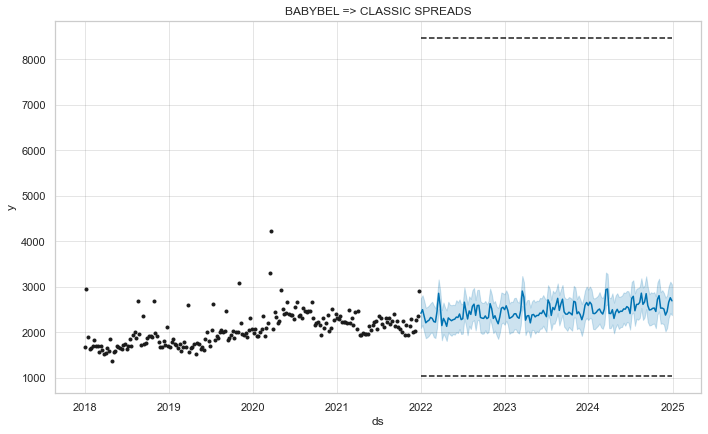

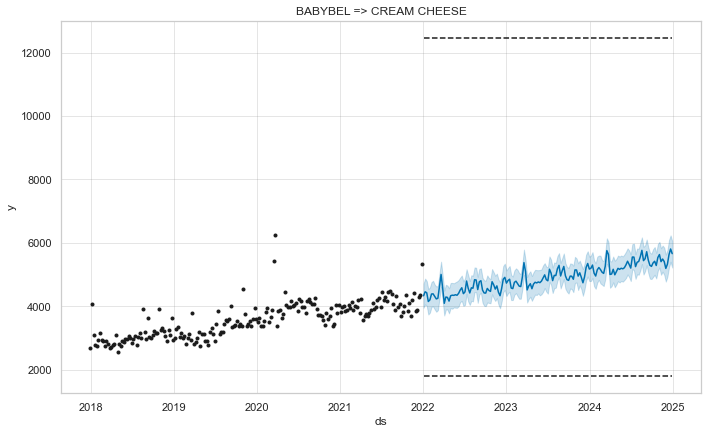

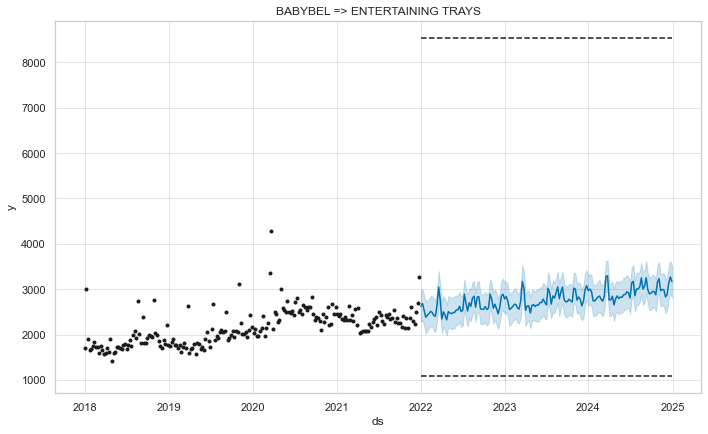

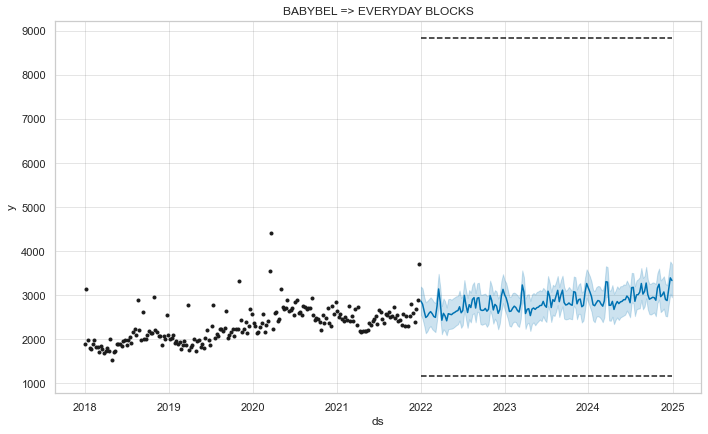

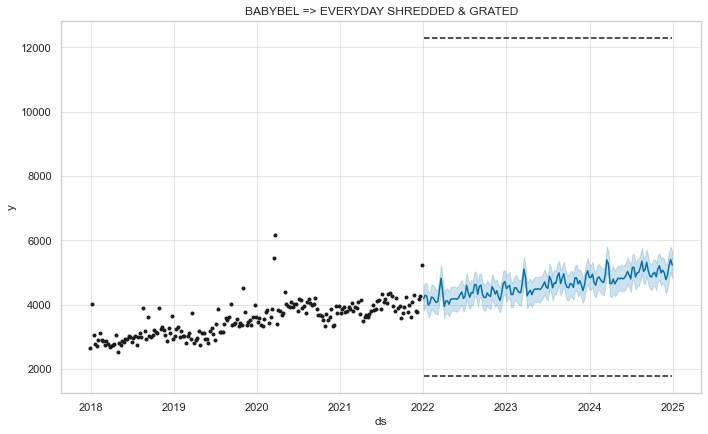

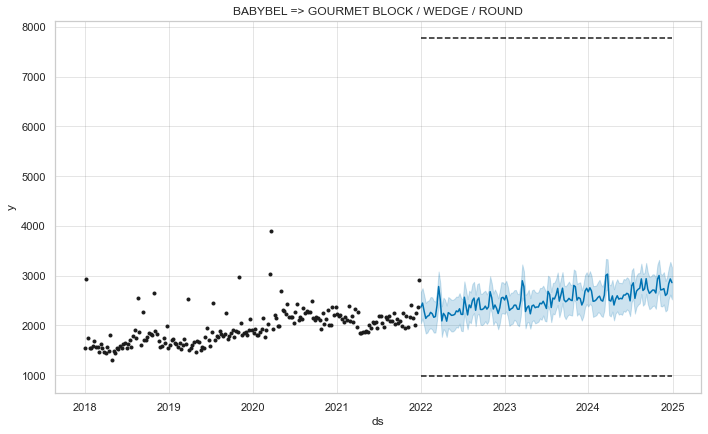

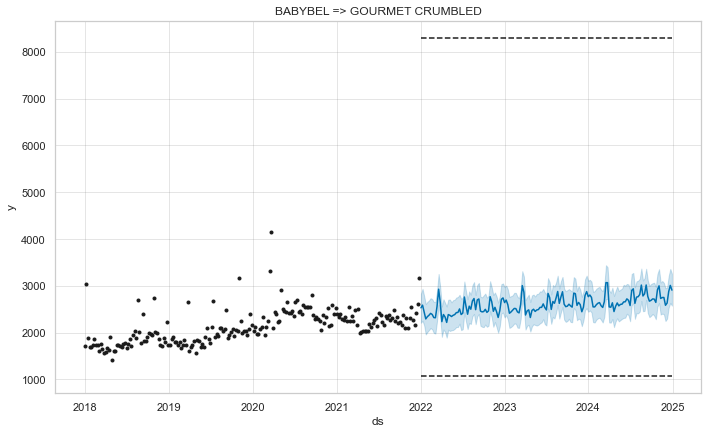

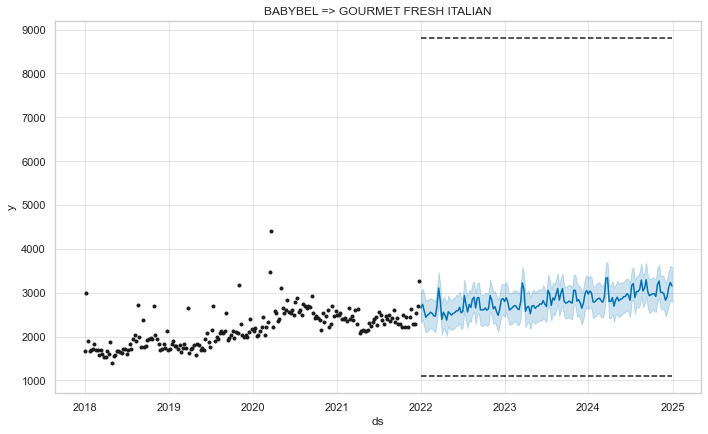

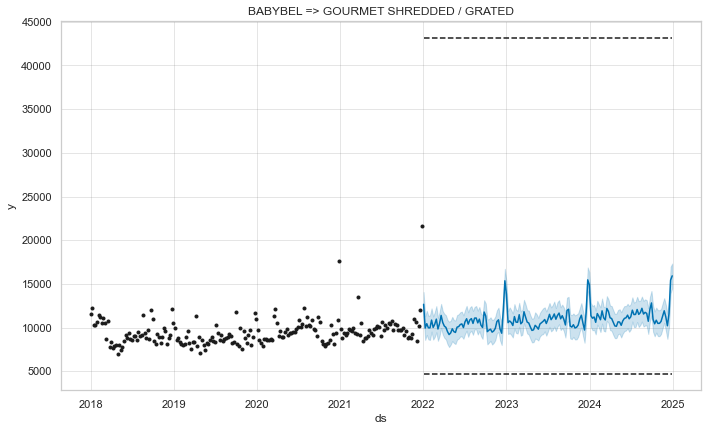

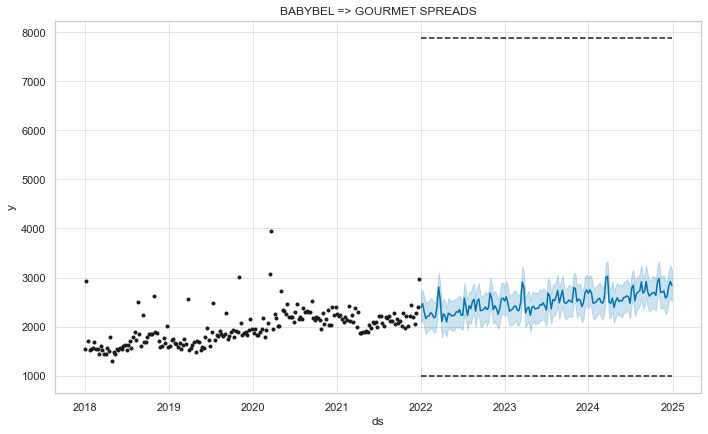

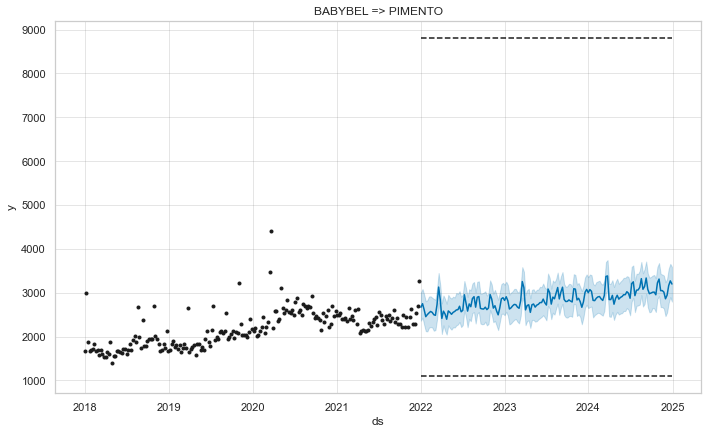

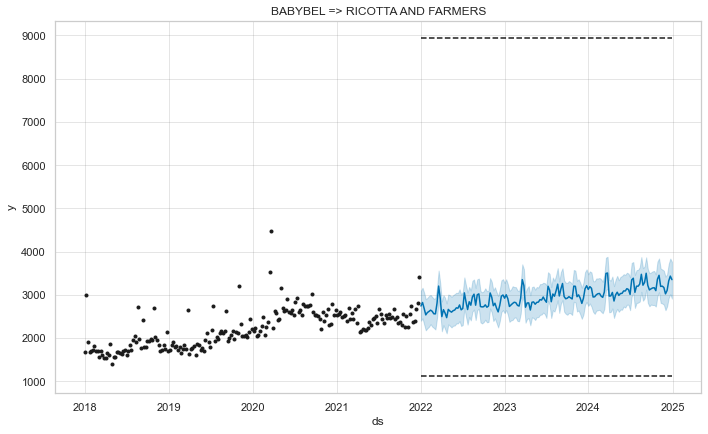

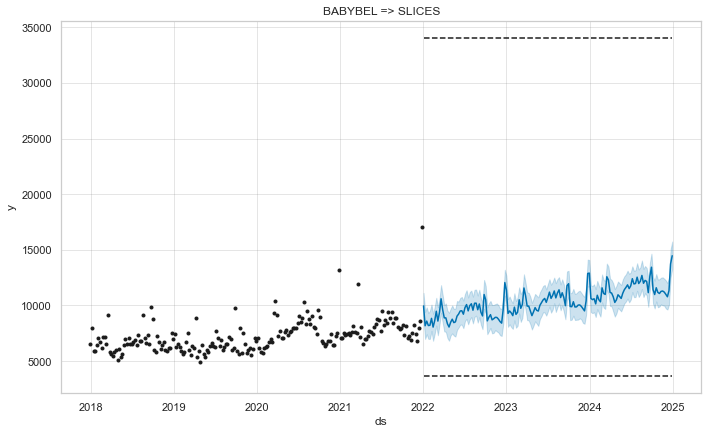

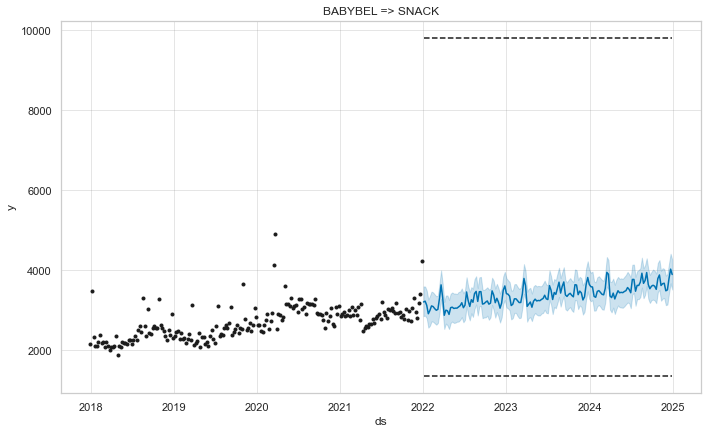

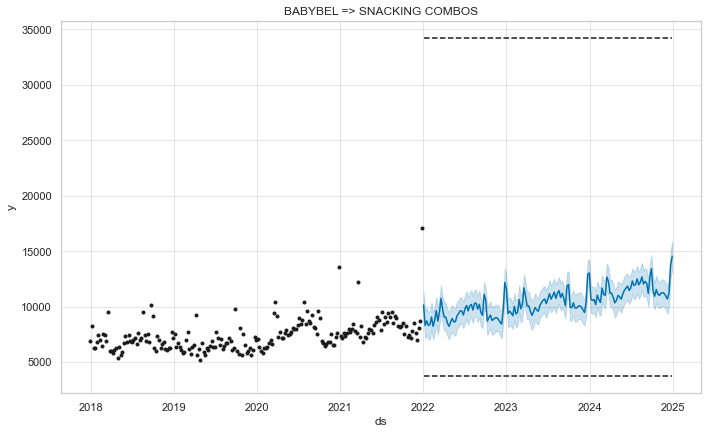

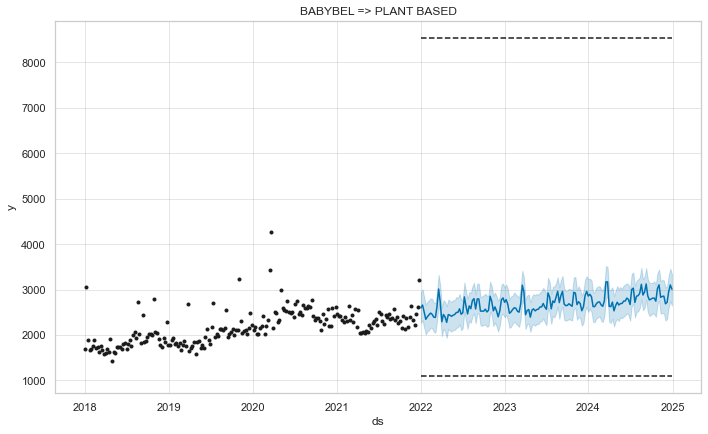

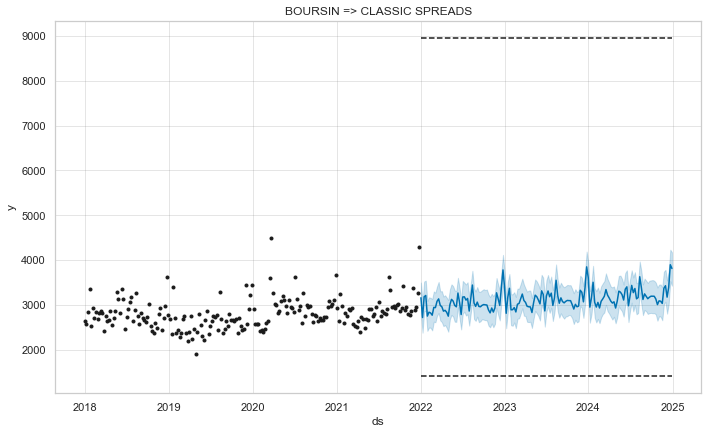

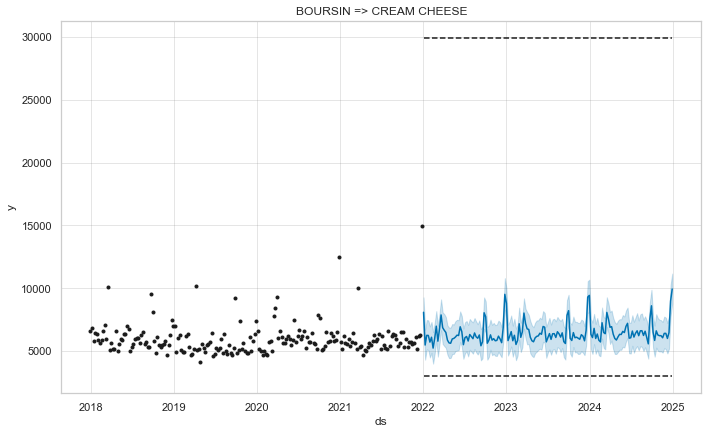

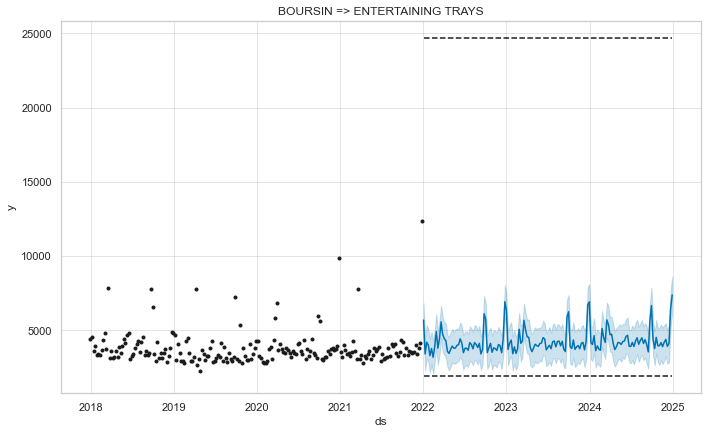

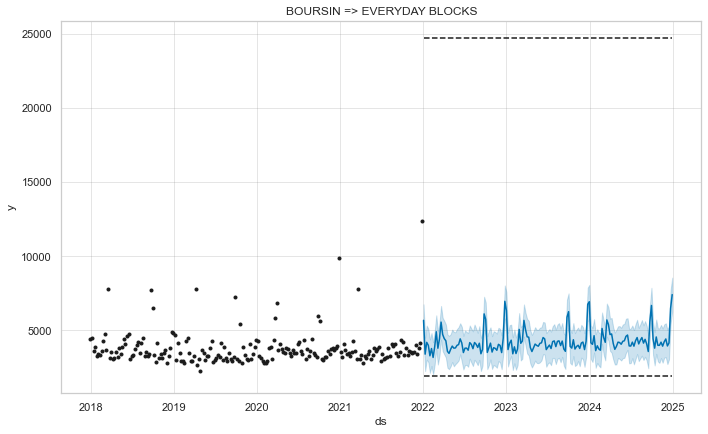

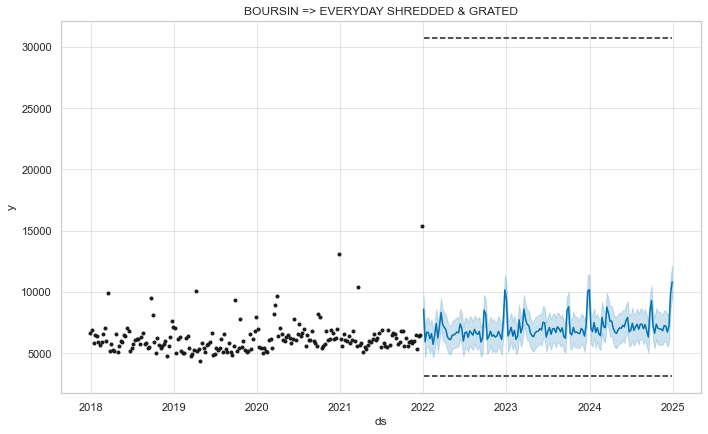

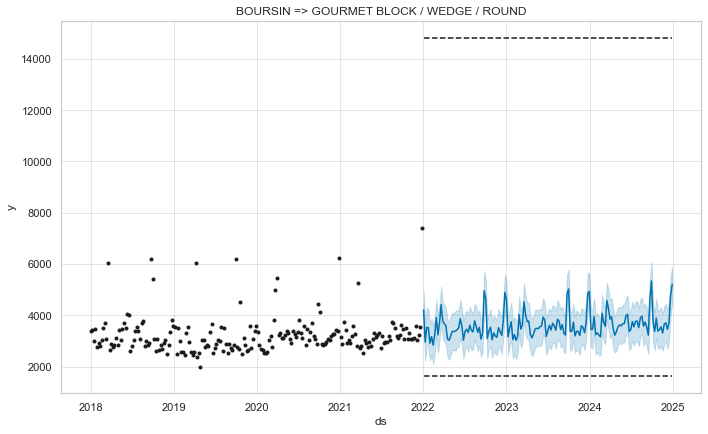

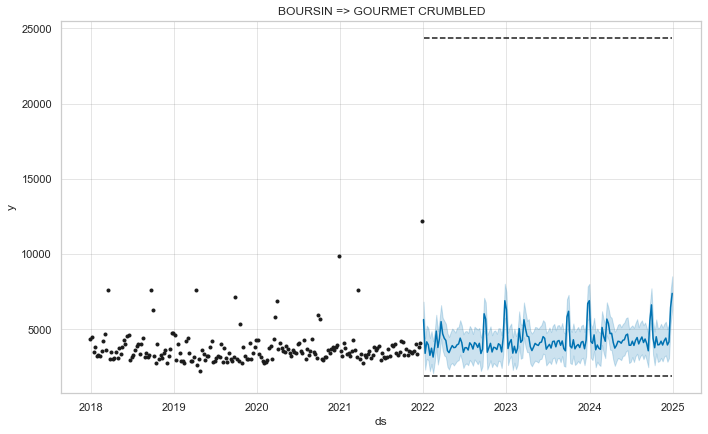

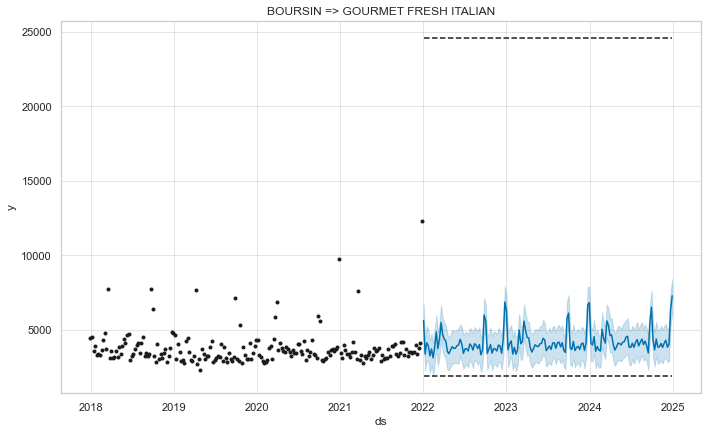

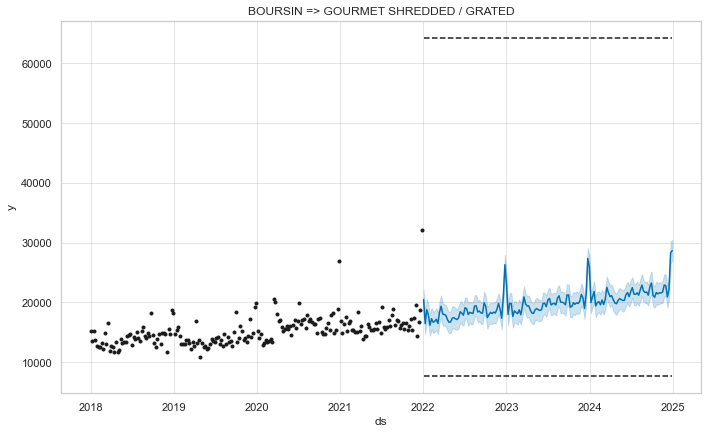

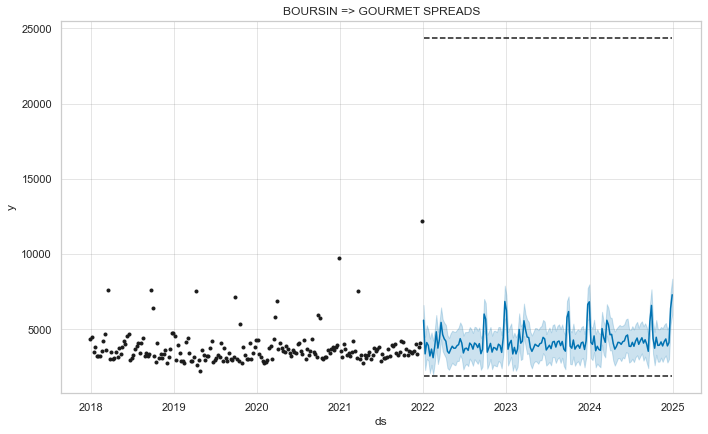

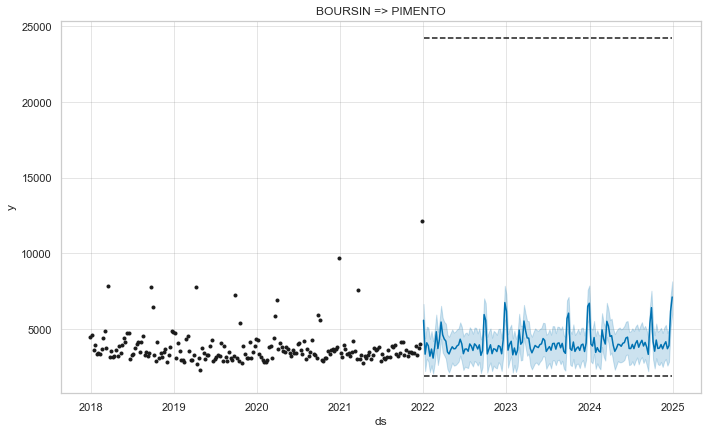

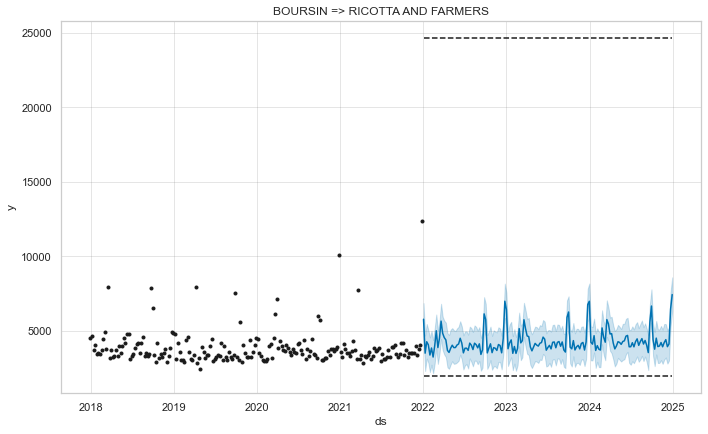

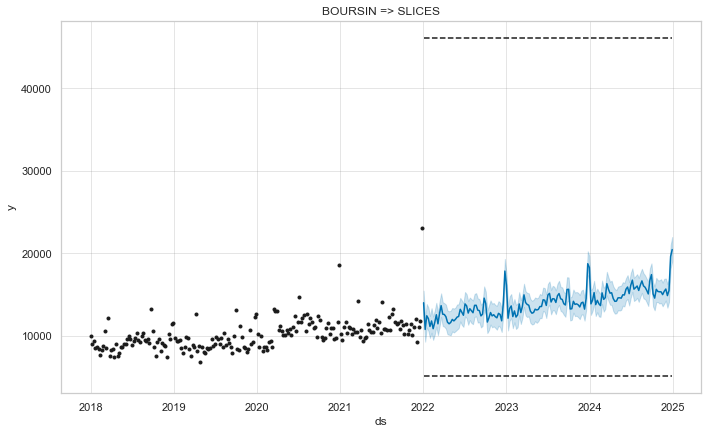

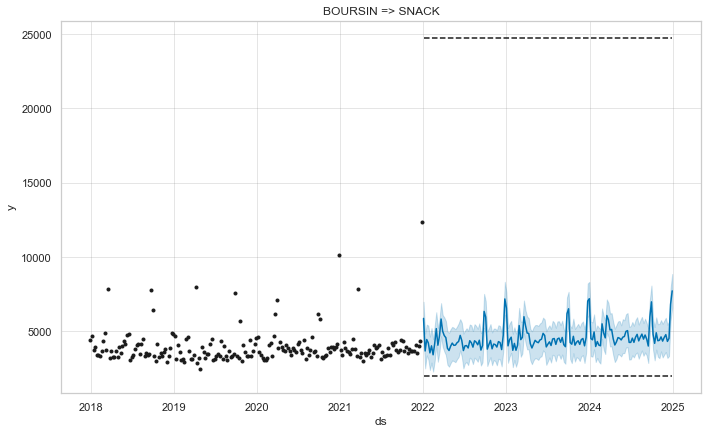

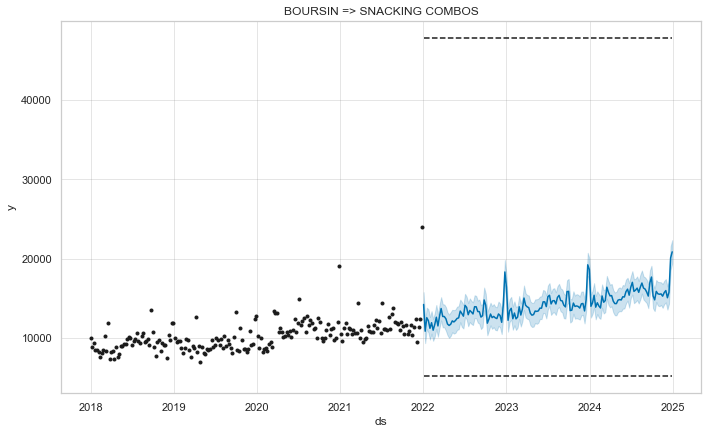

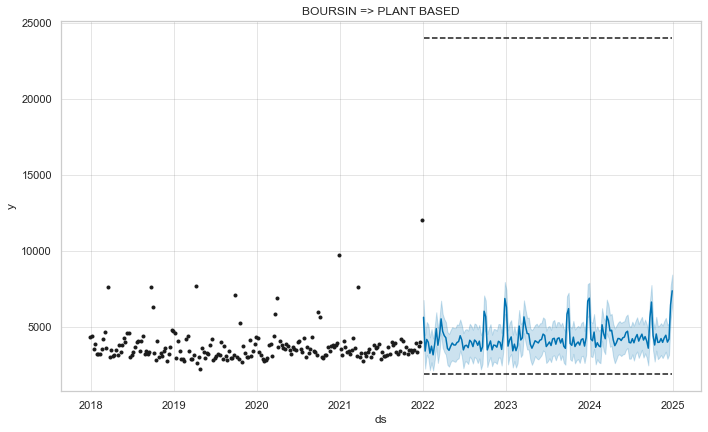

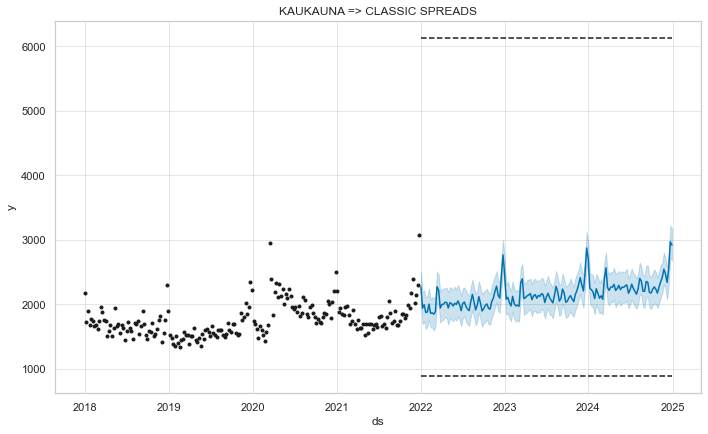

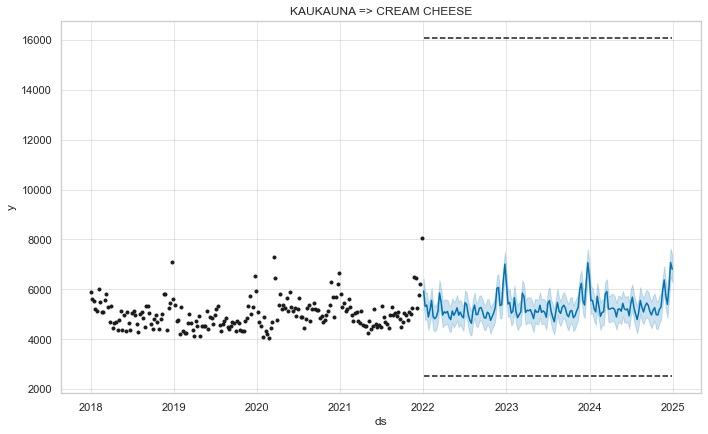

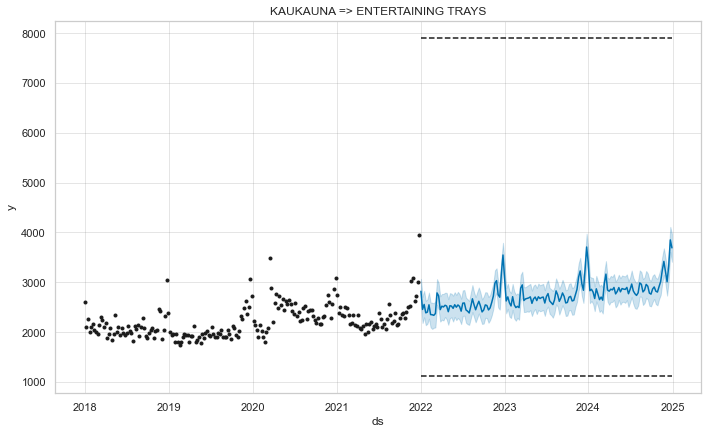

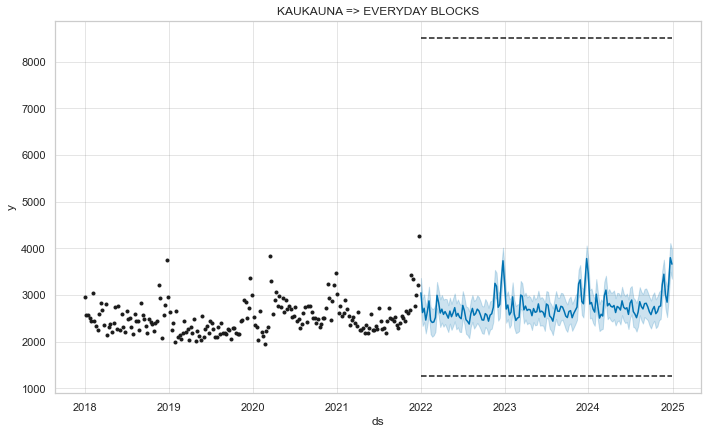

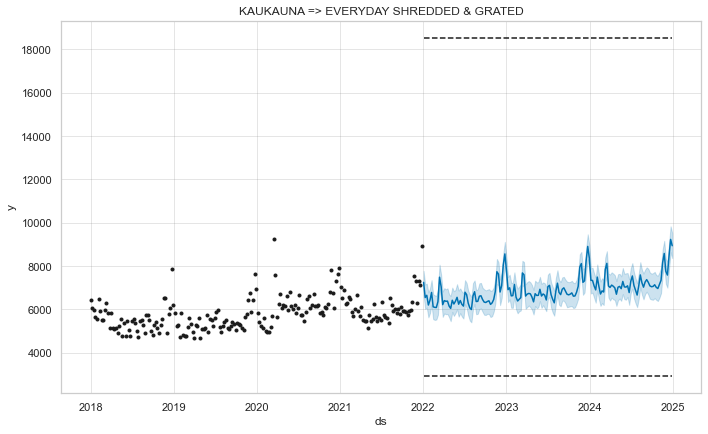

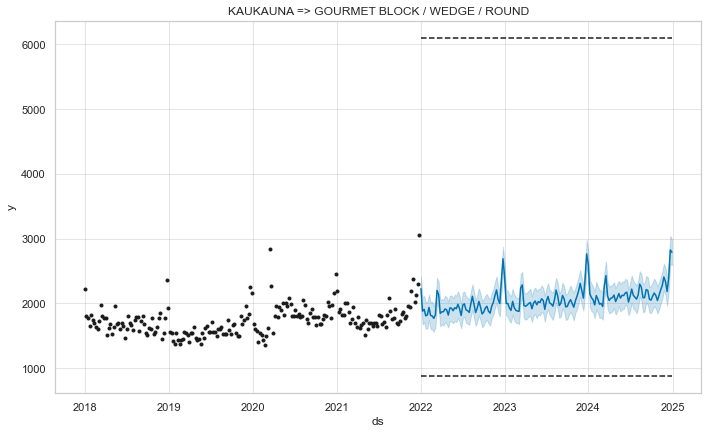

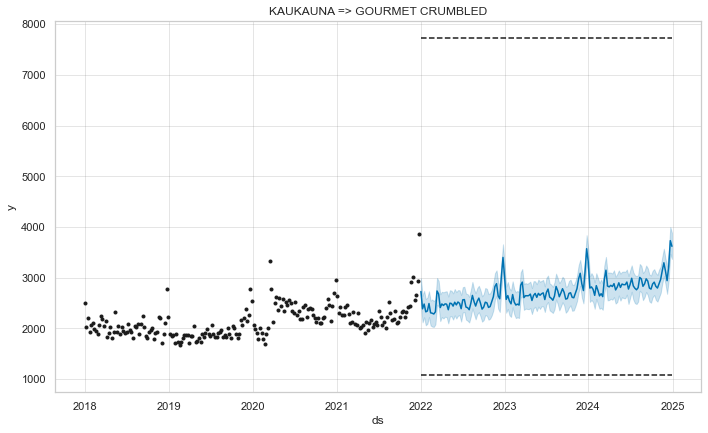

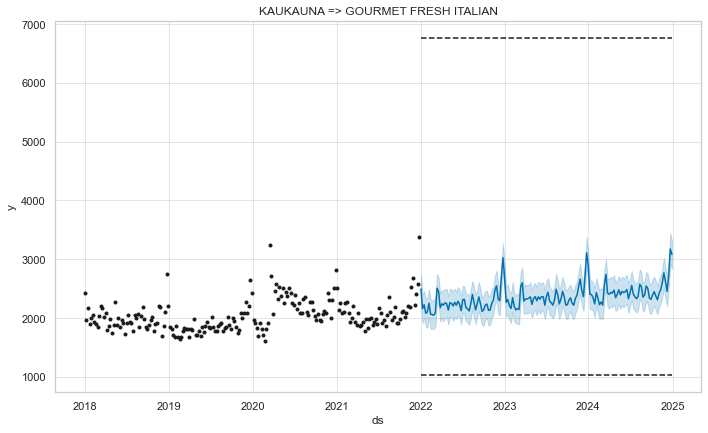

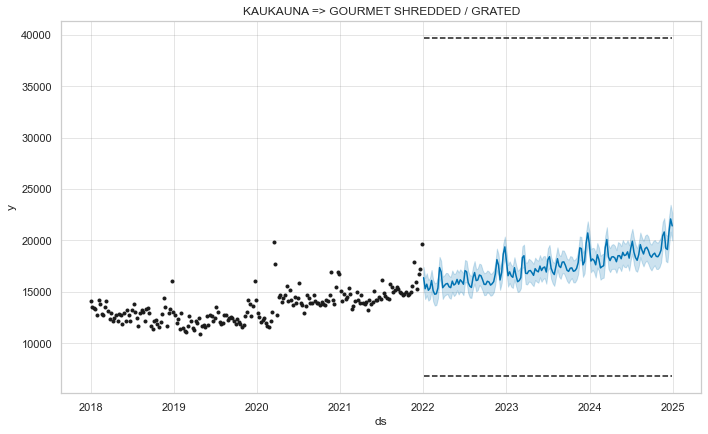

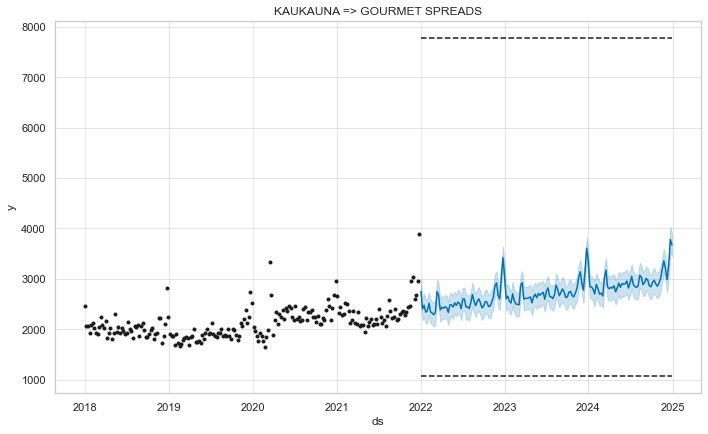

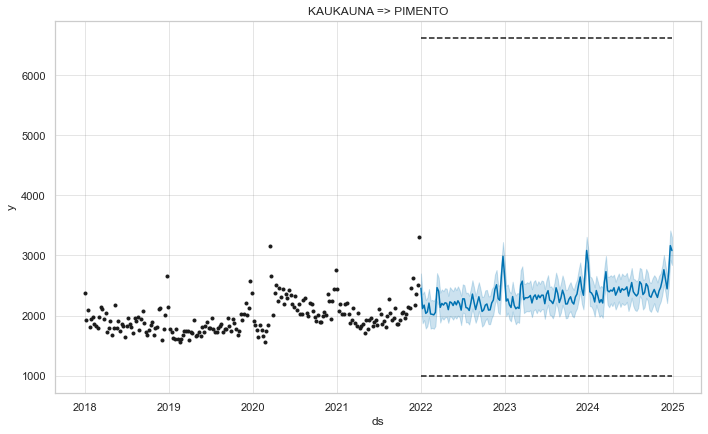

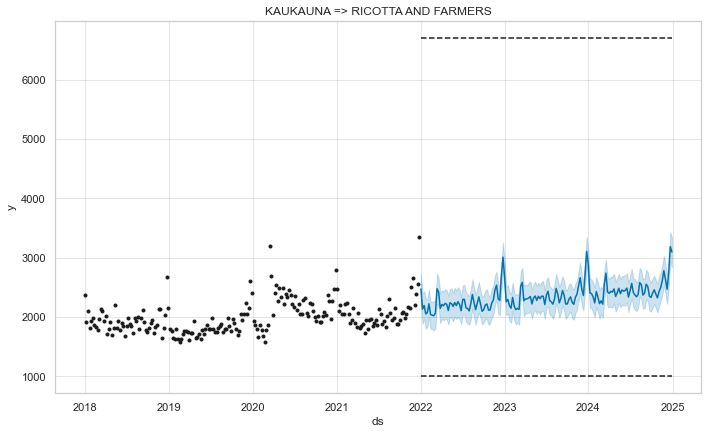

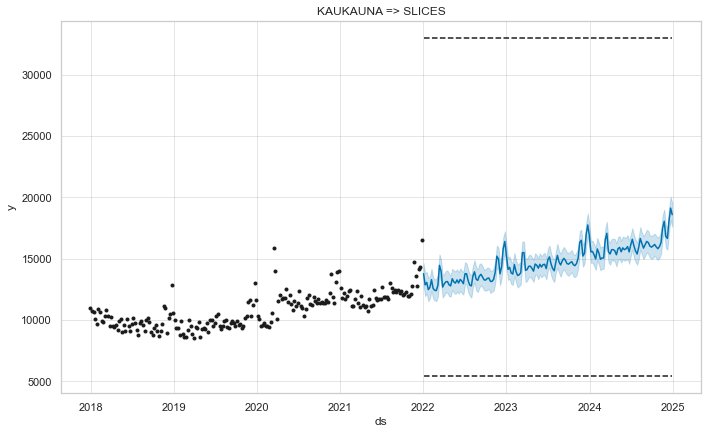

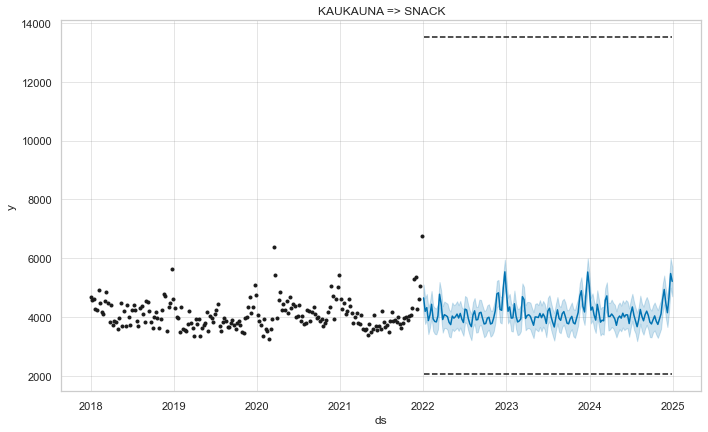

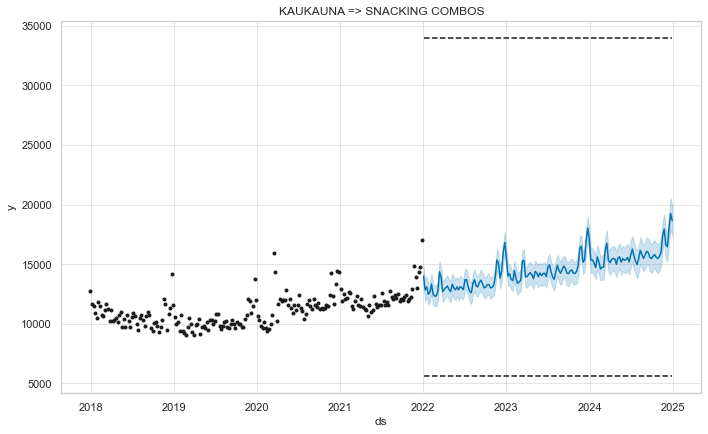

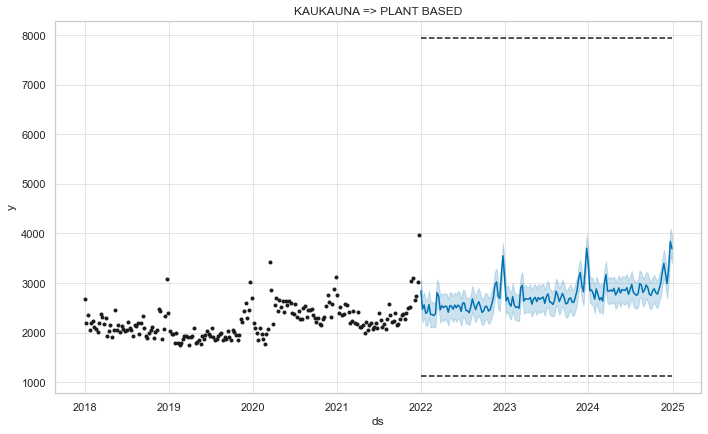

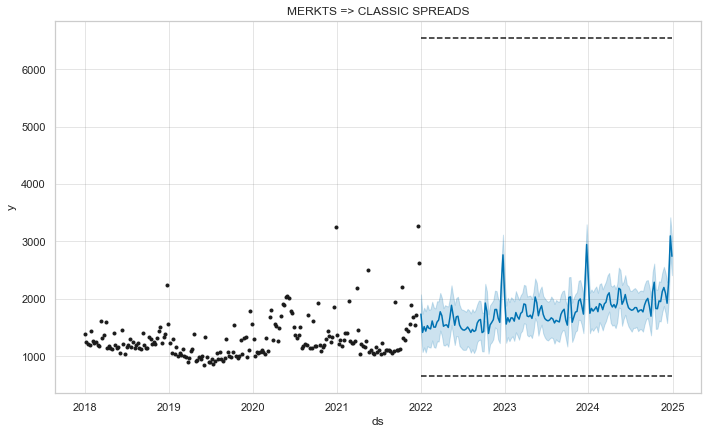

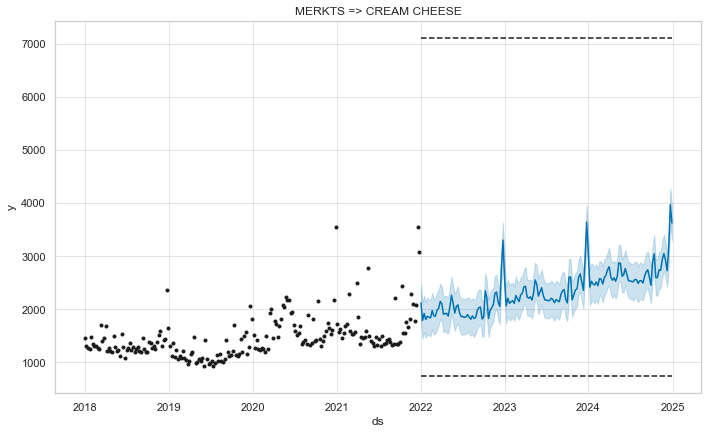

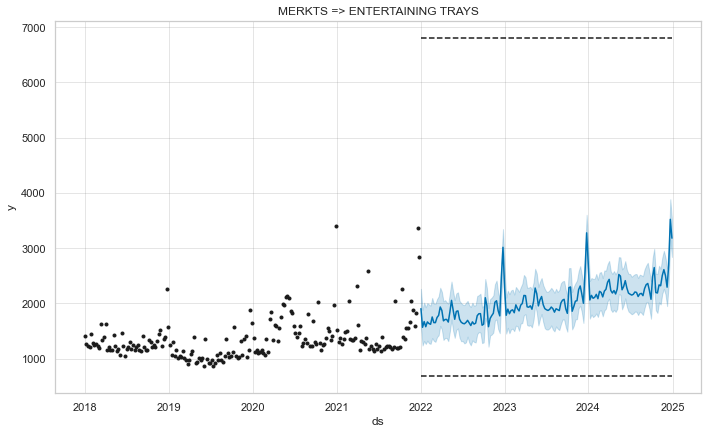

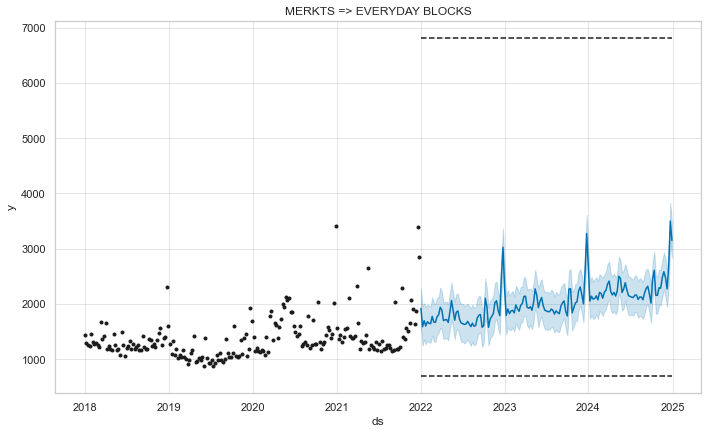

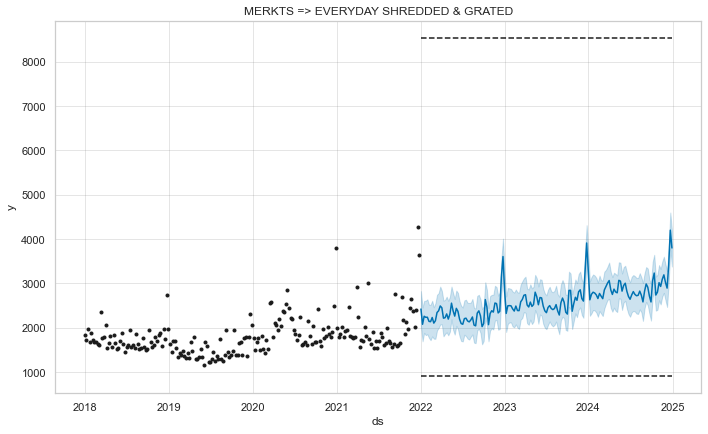

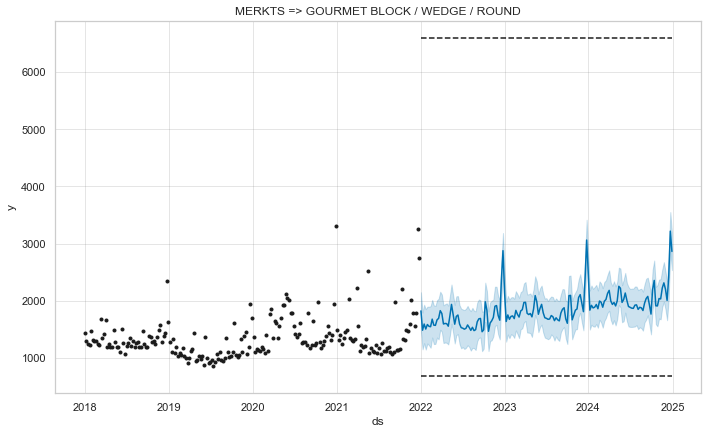

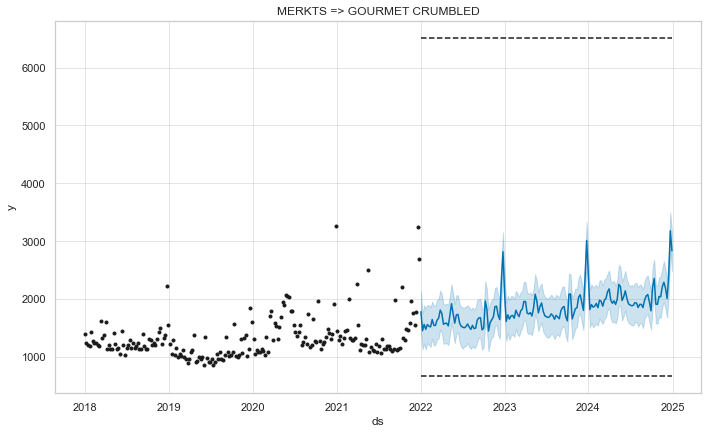

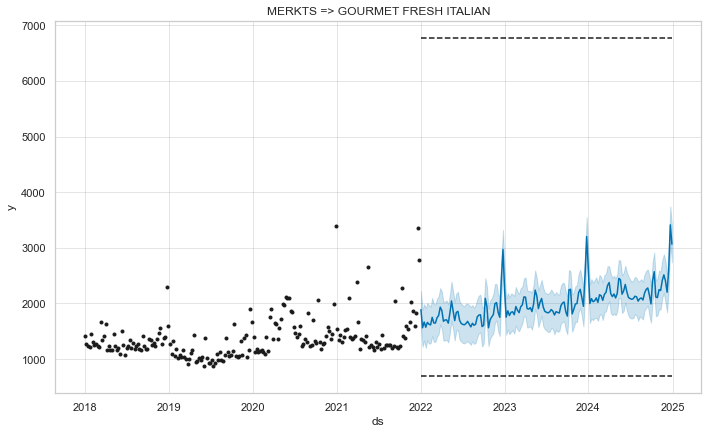

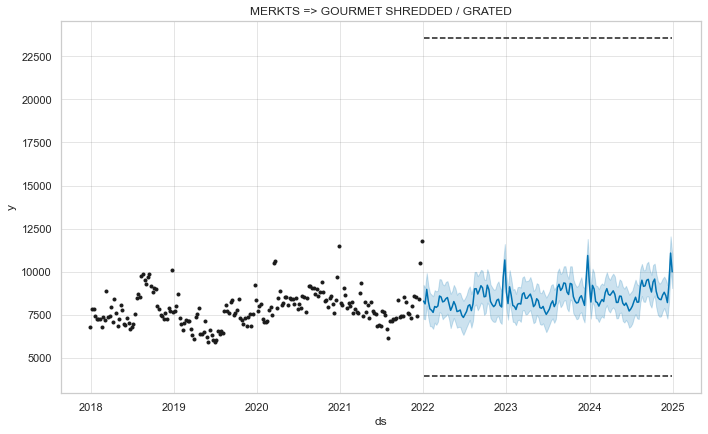

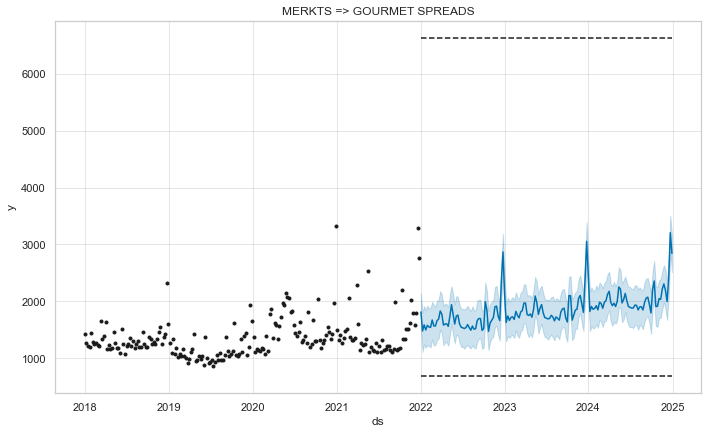

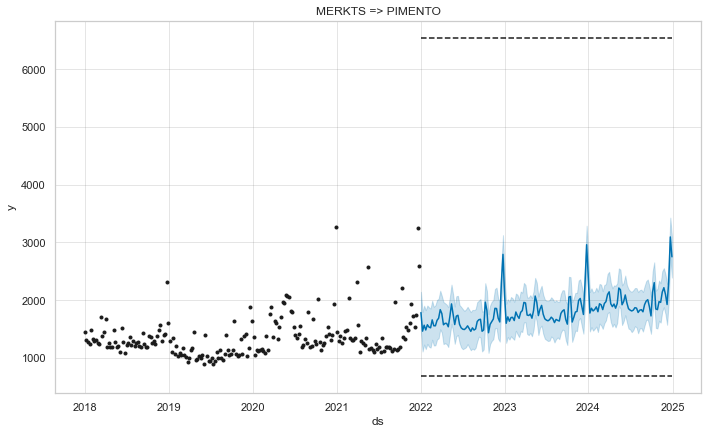

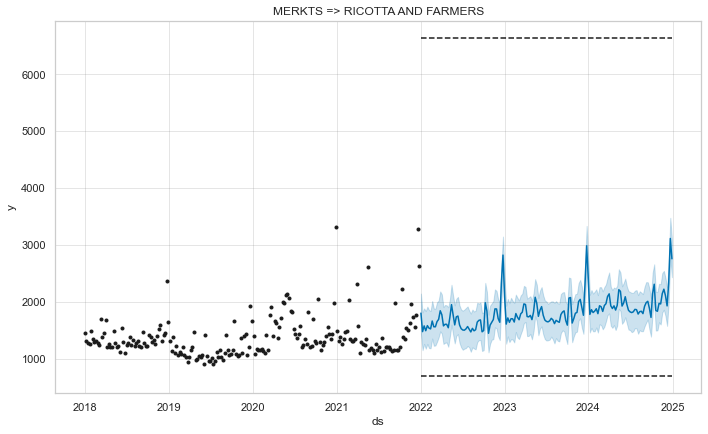

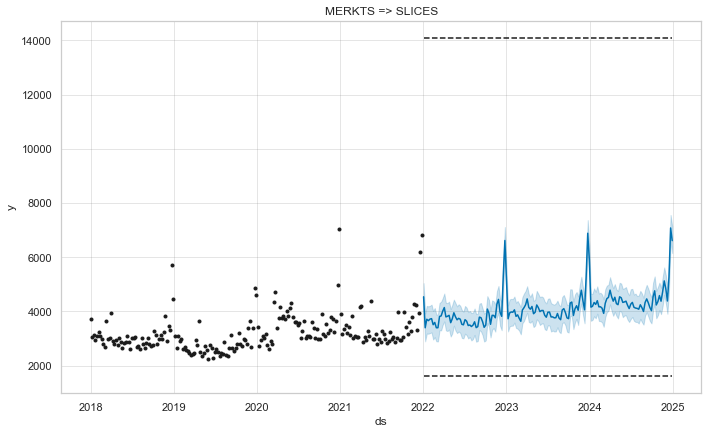

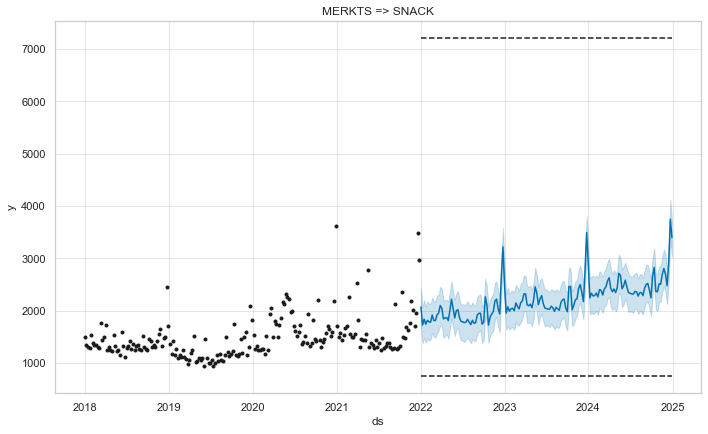

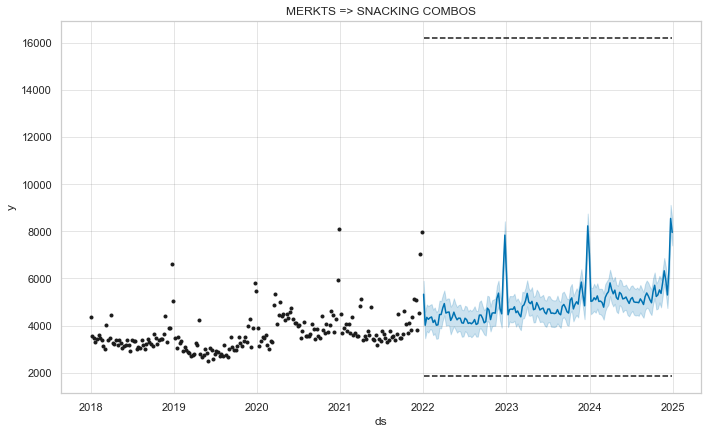

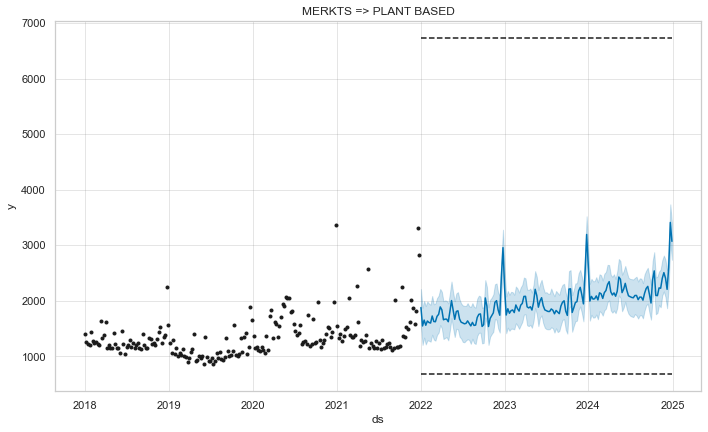

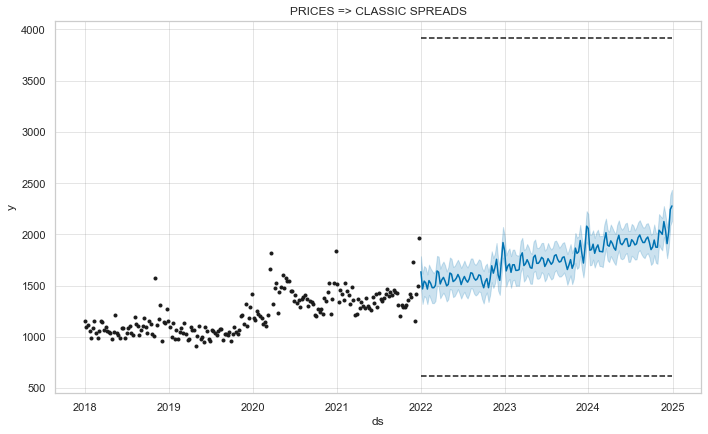

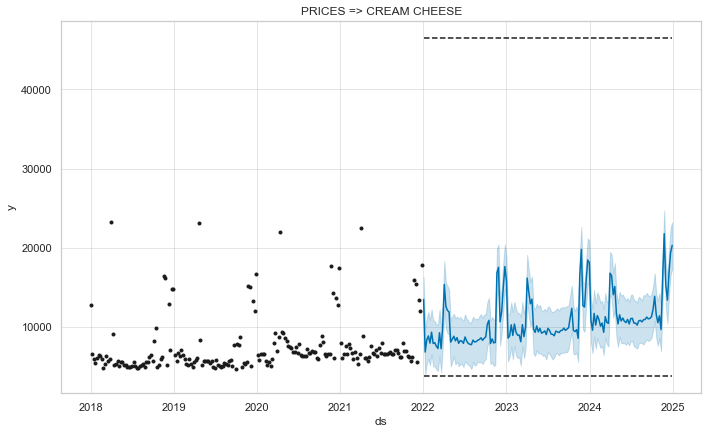

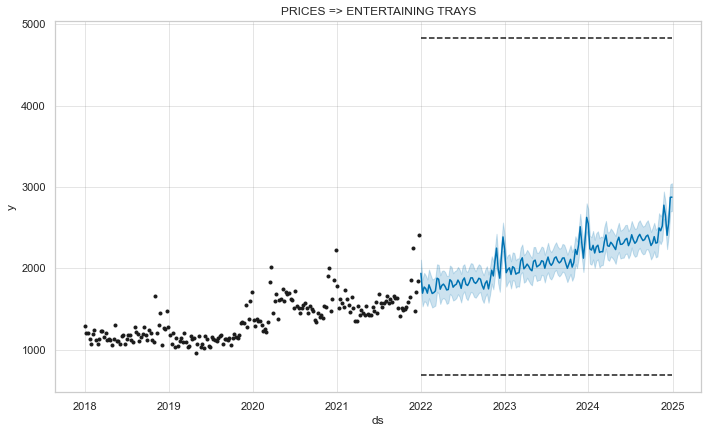

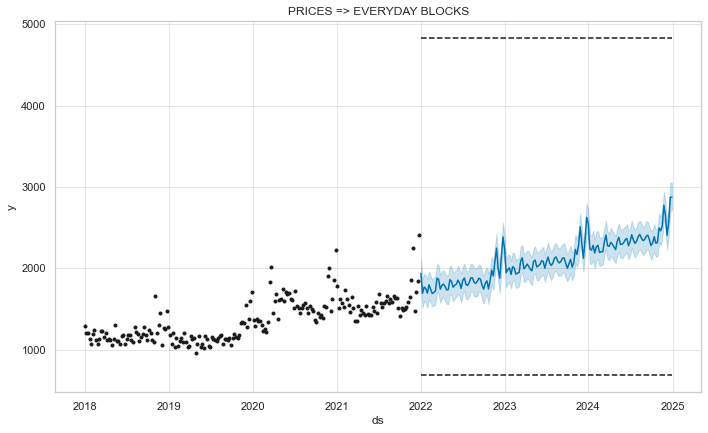

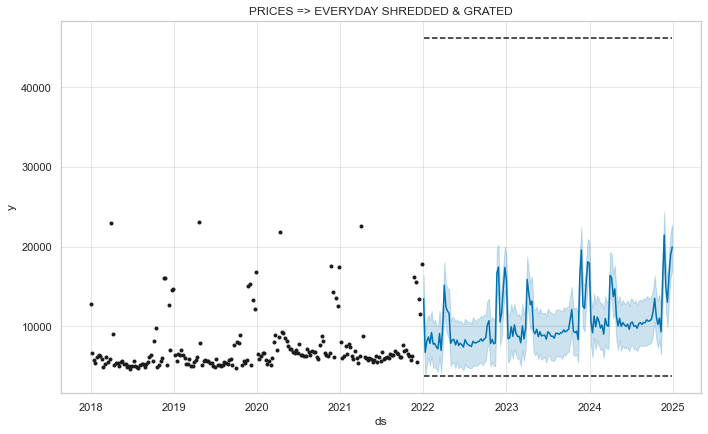

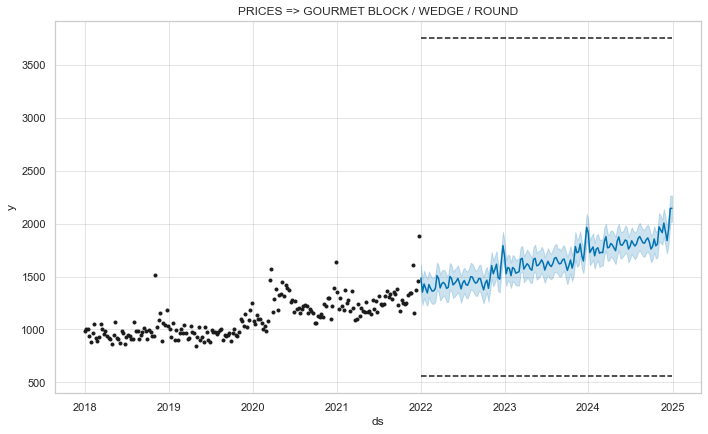

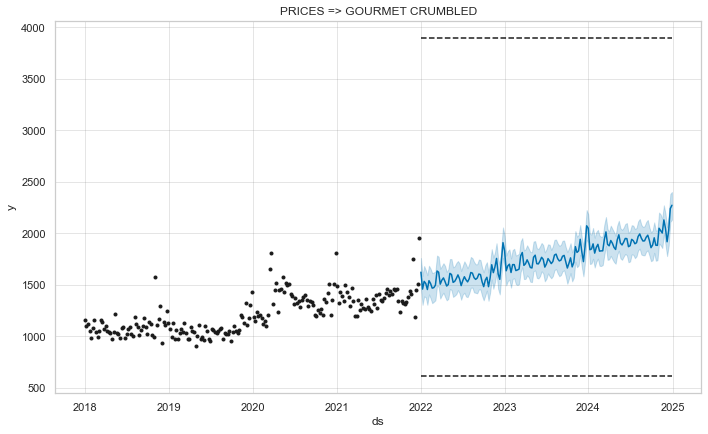

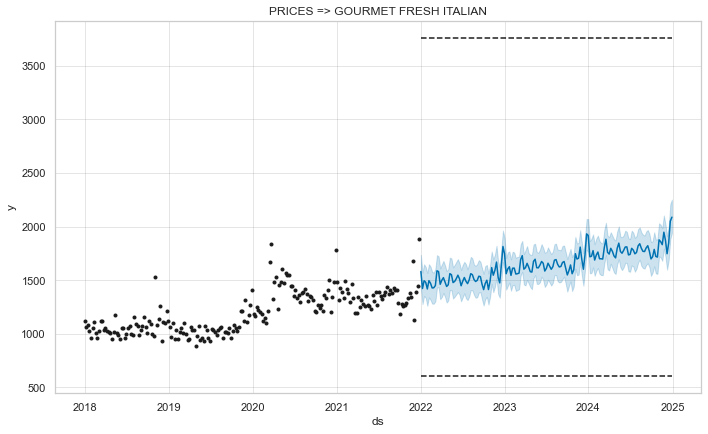

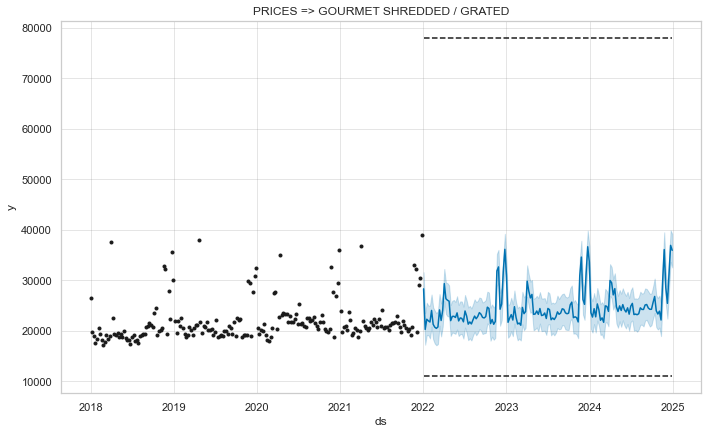

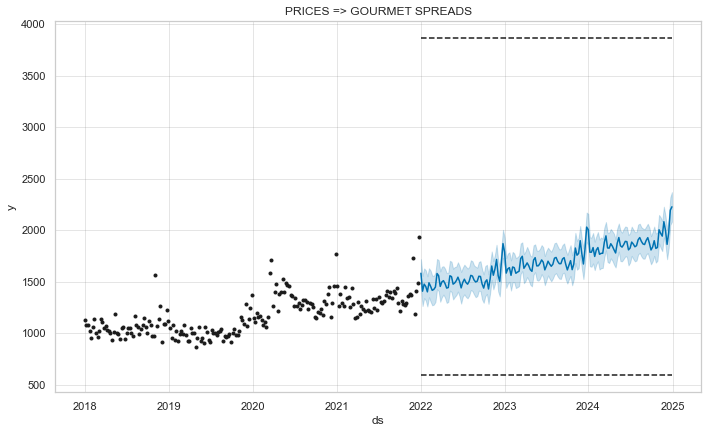

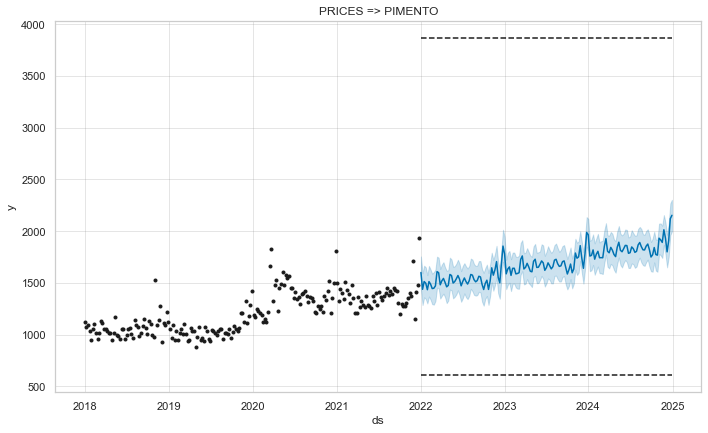

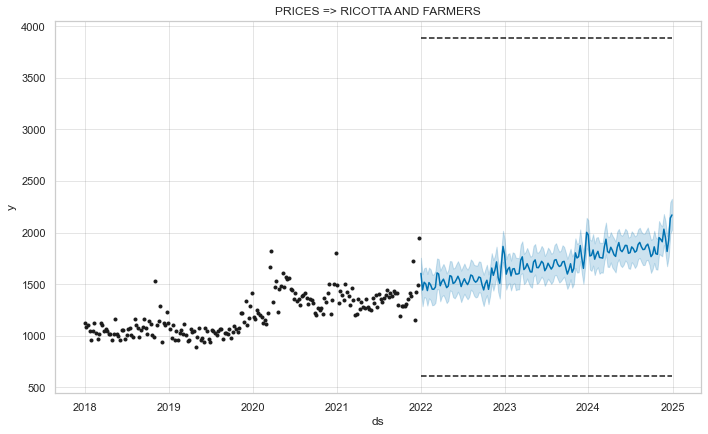

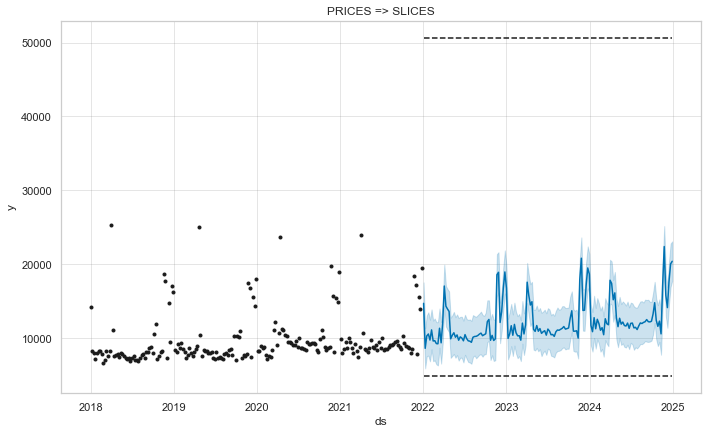

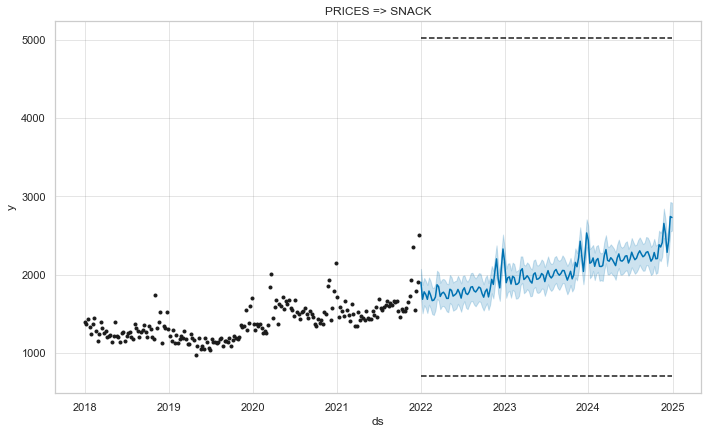

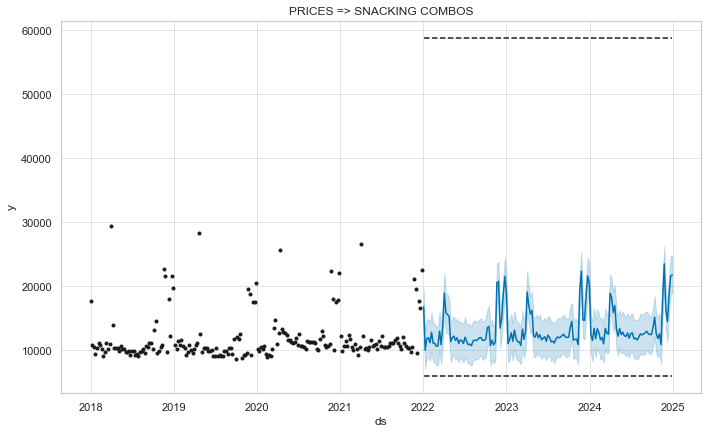

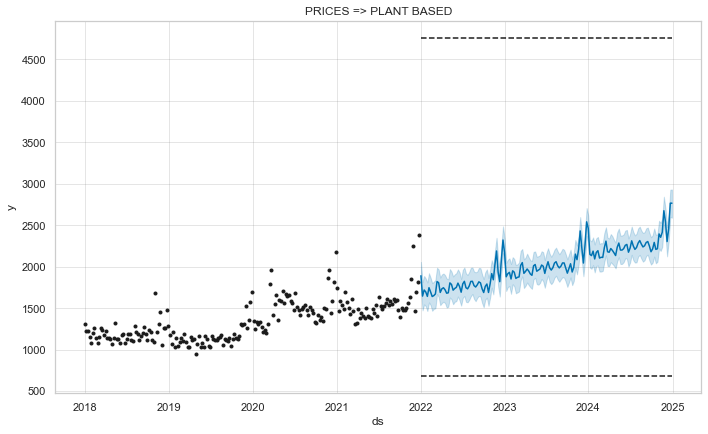

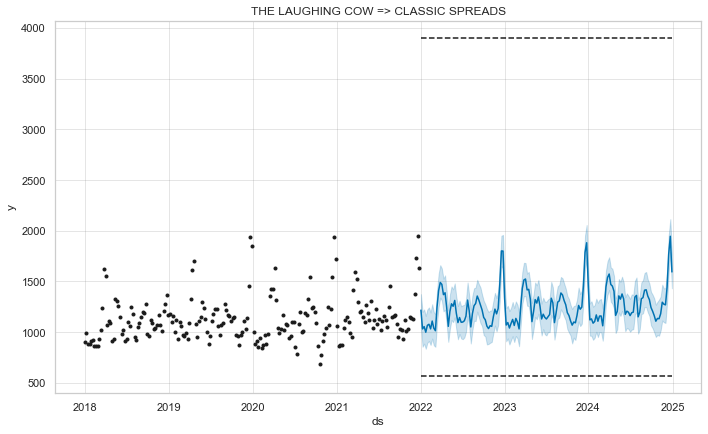

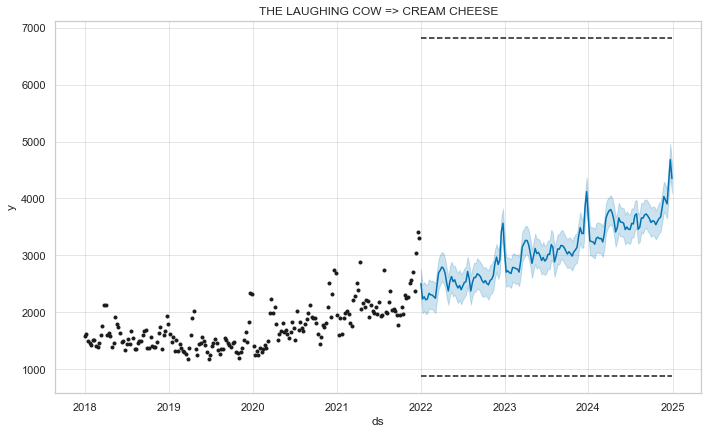

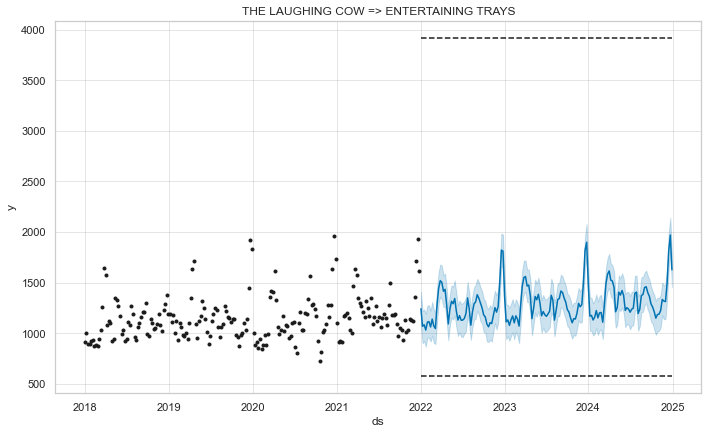

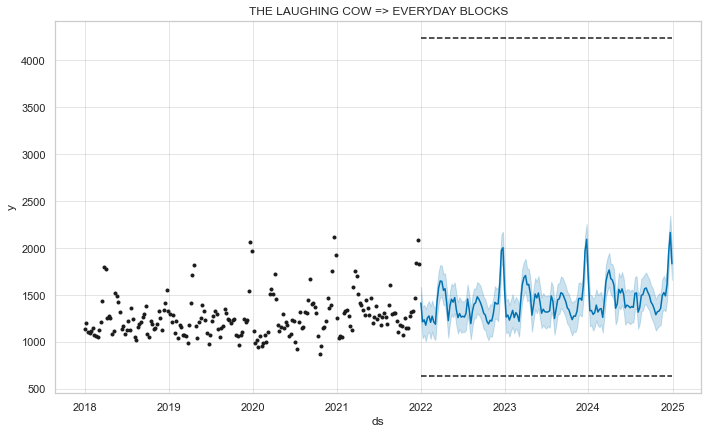

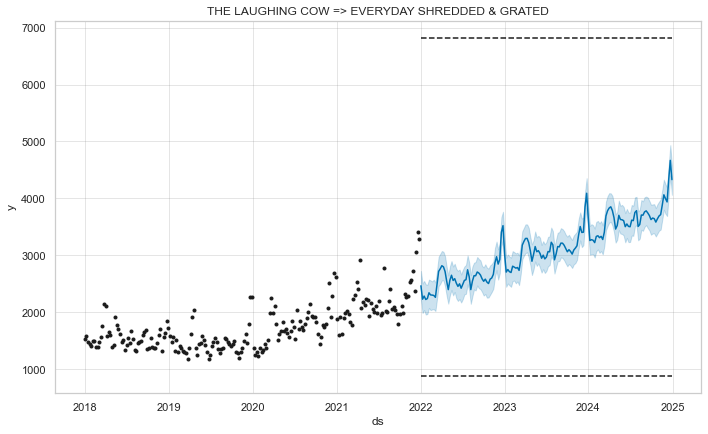

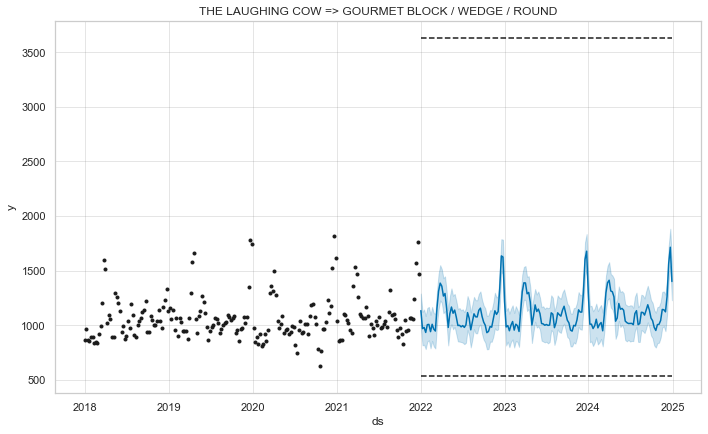

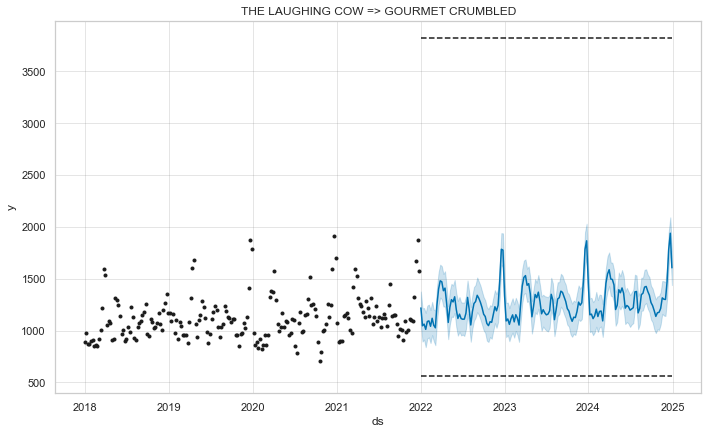

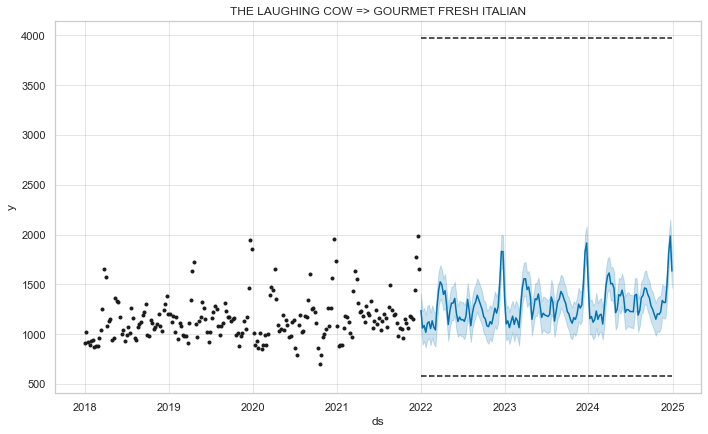

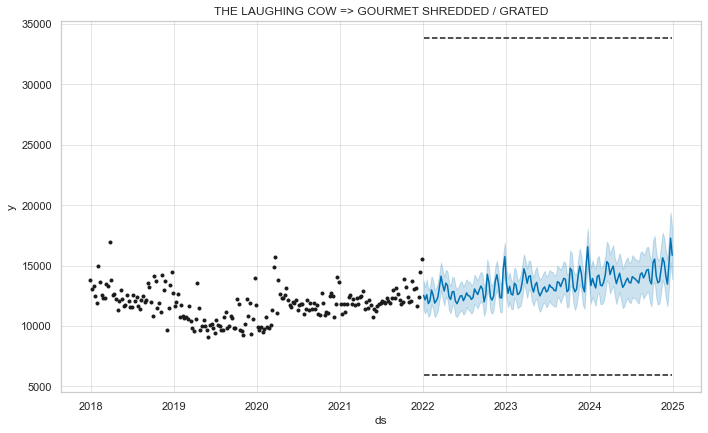

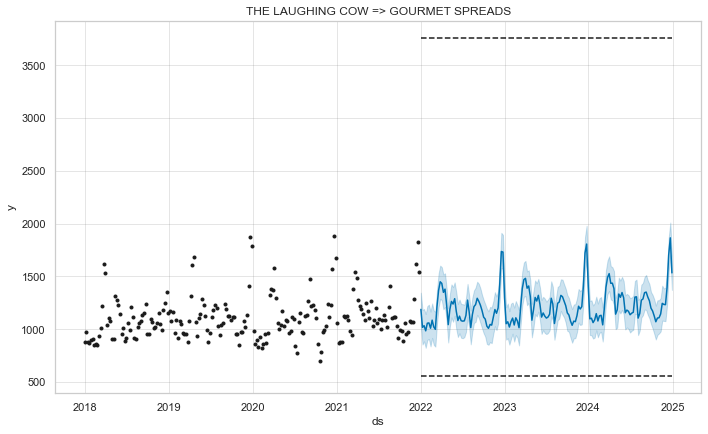

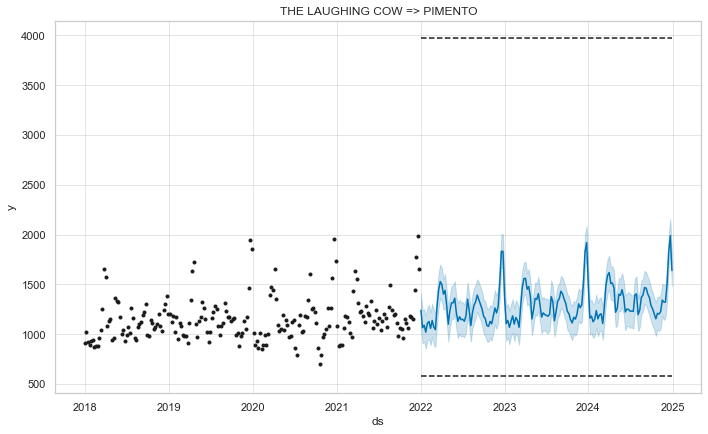

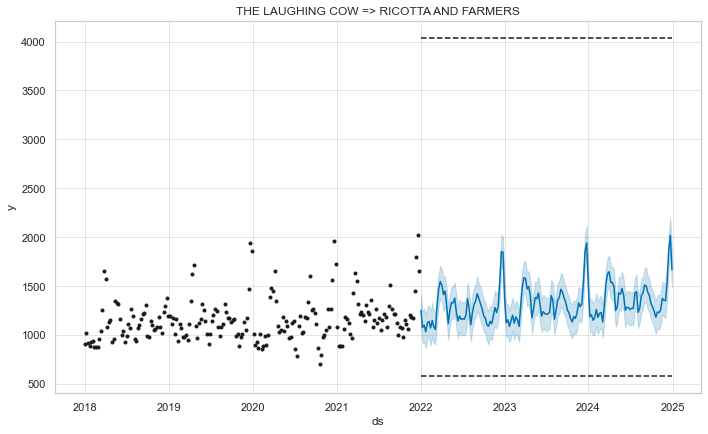

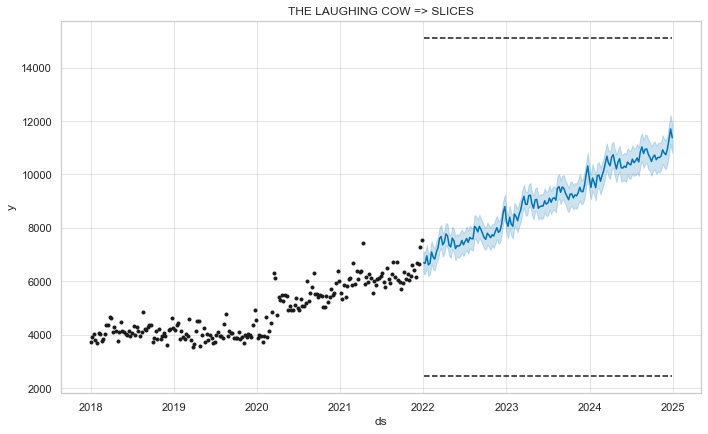

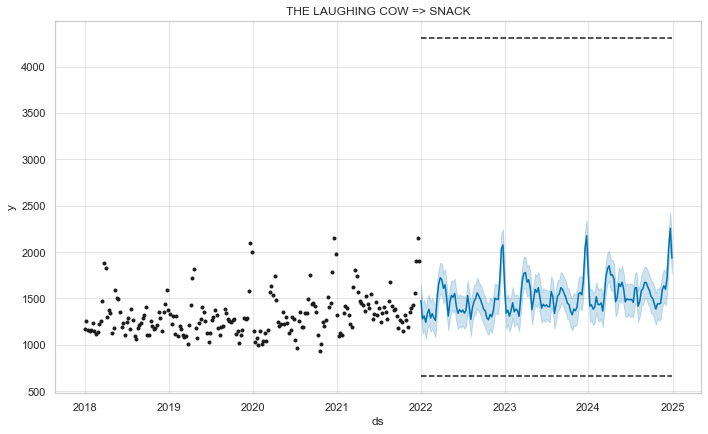

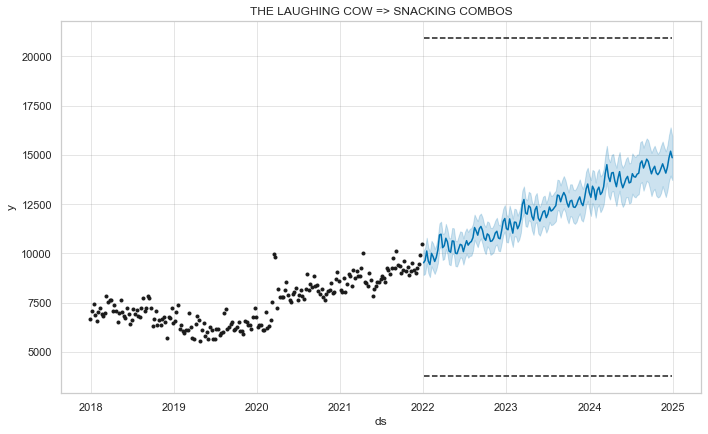

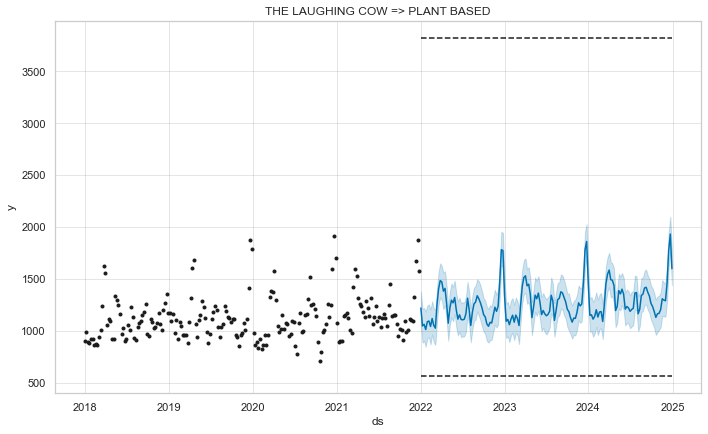

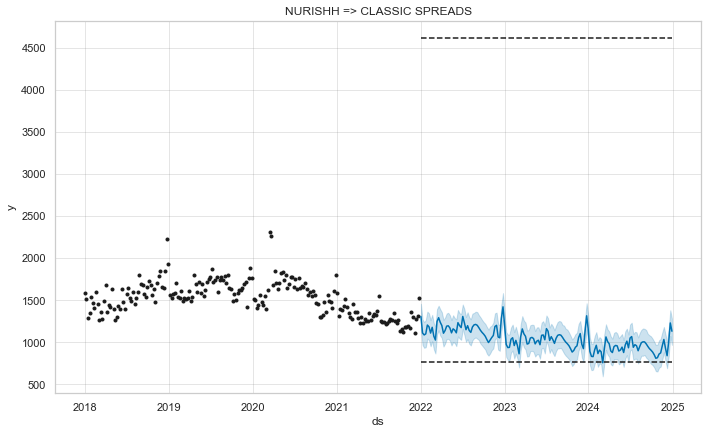

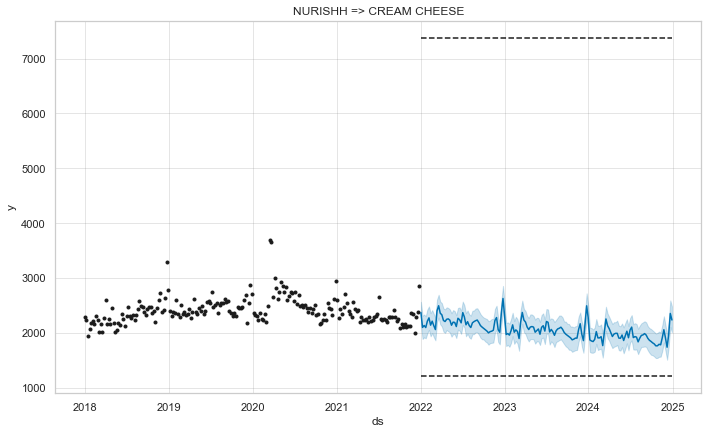

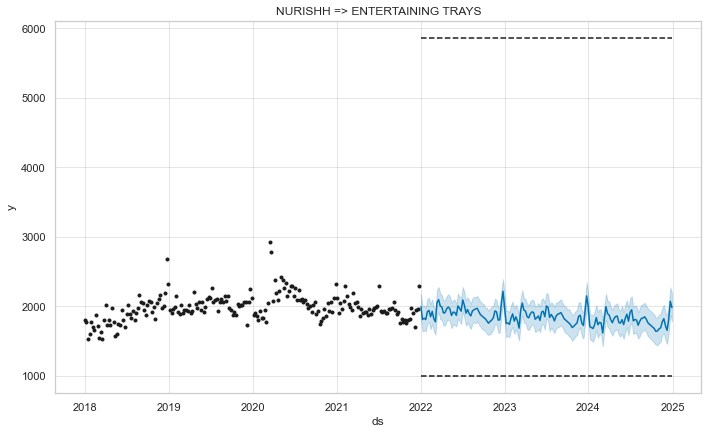

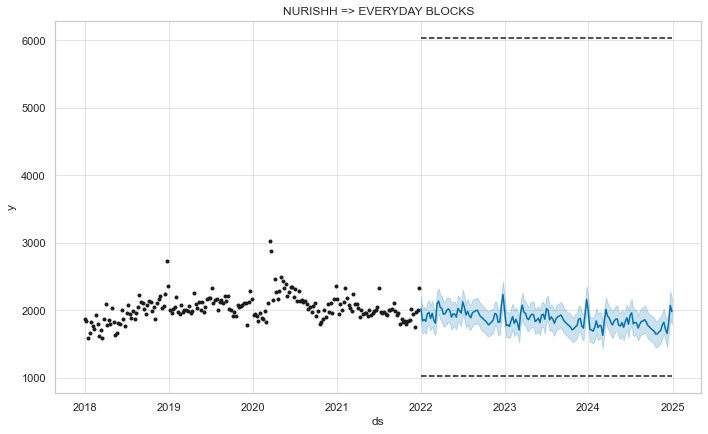

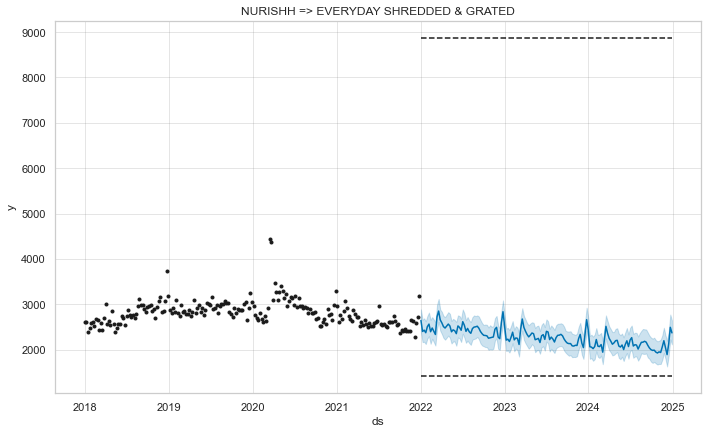

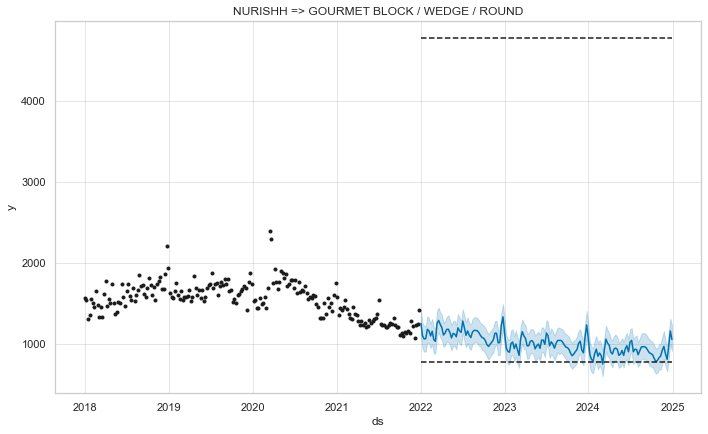

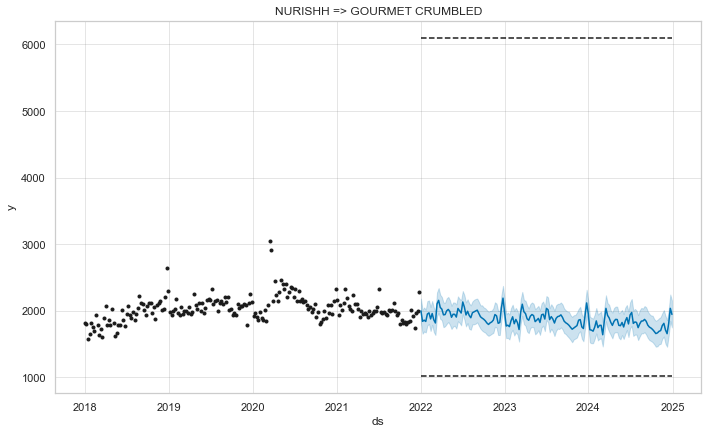

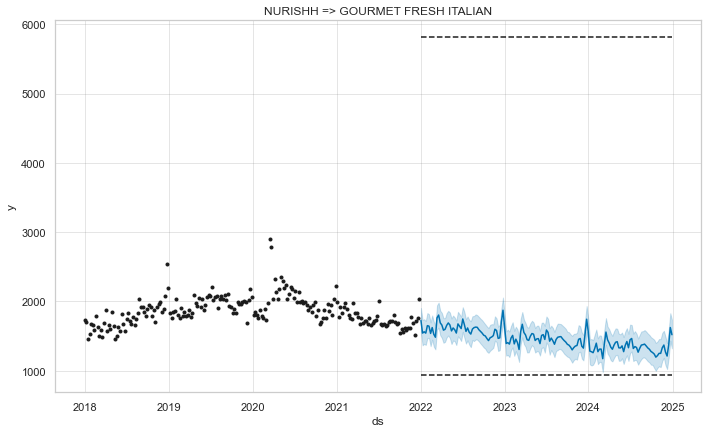

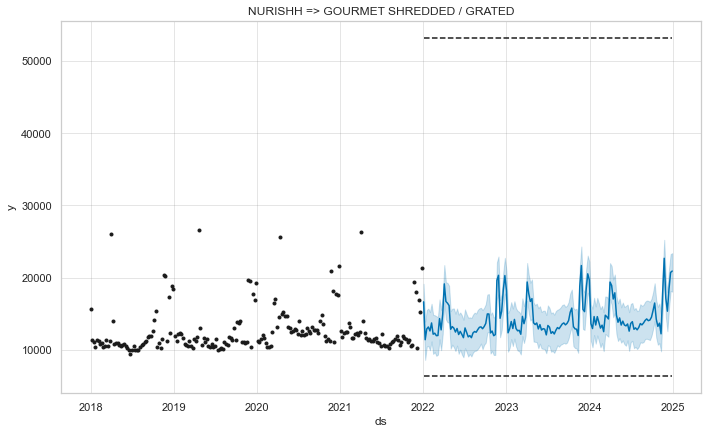

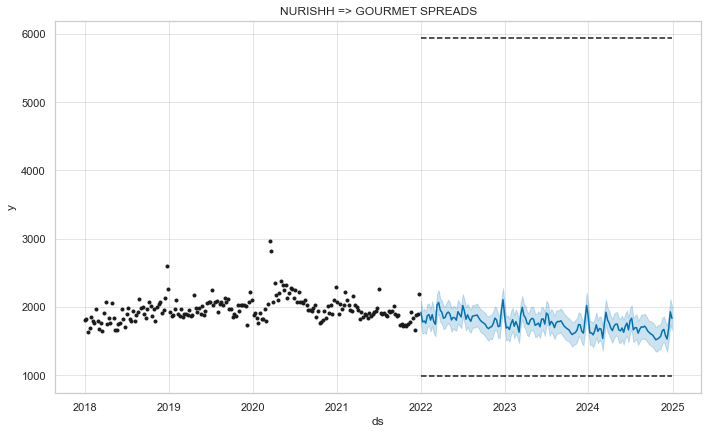

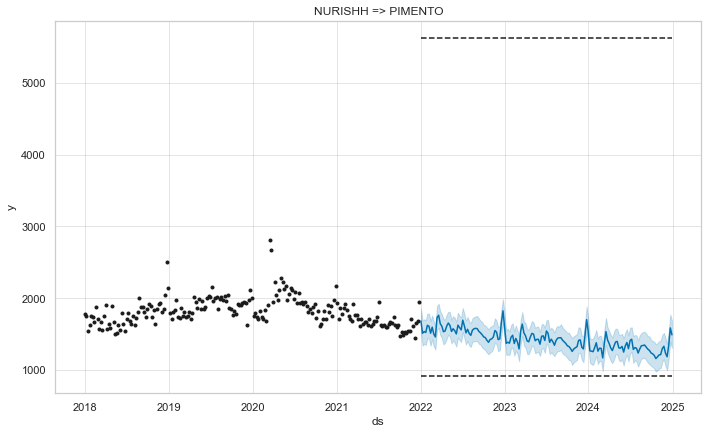

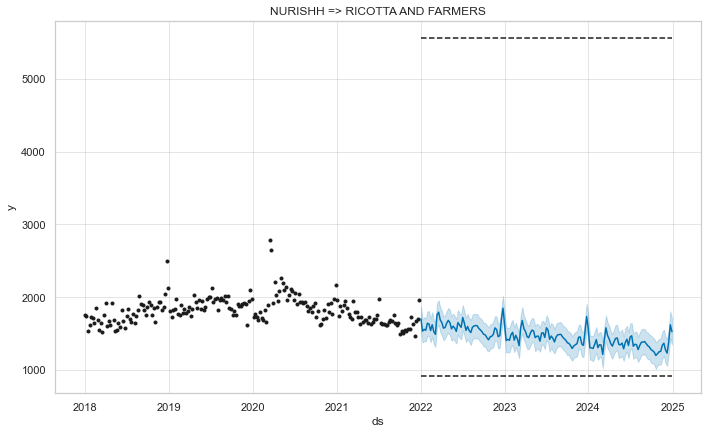

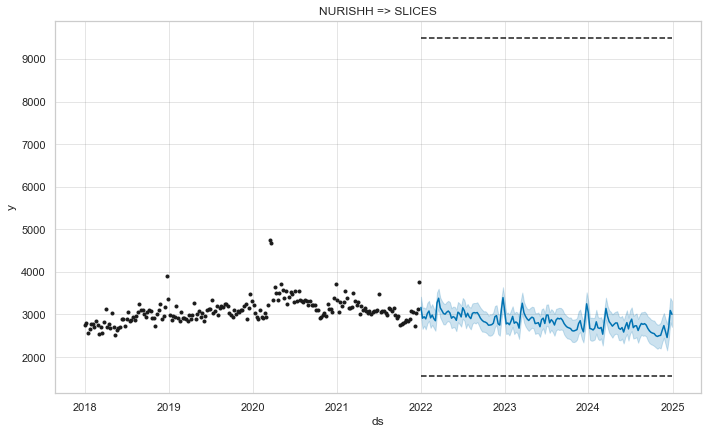

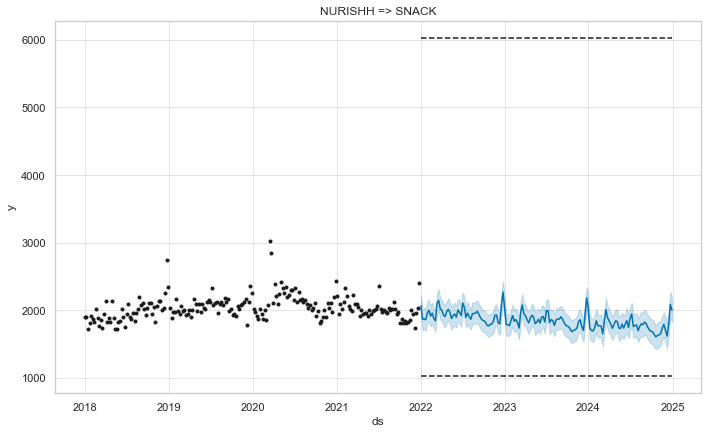

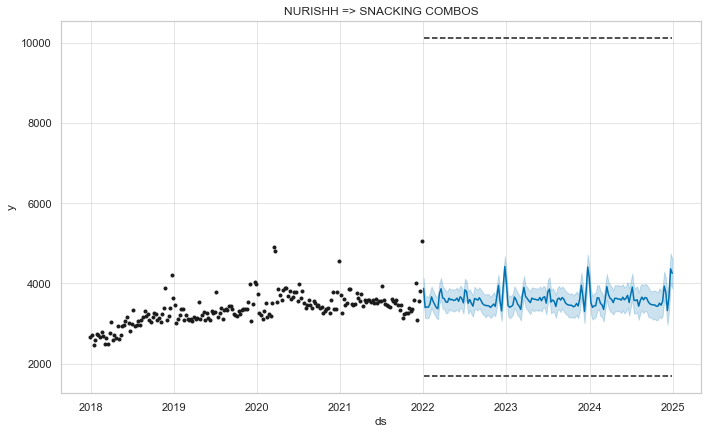

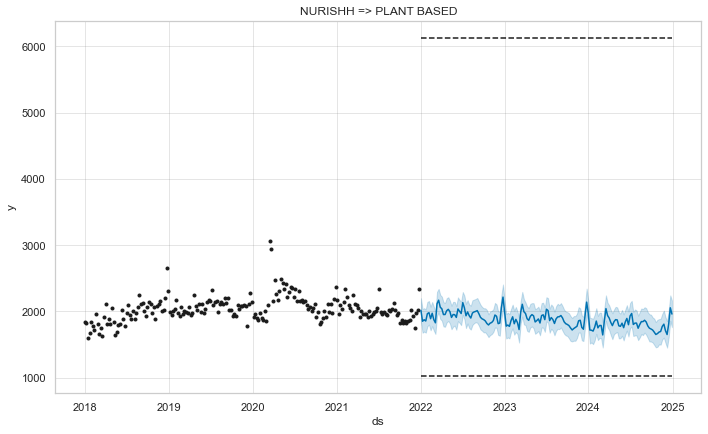

In [60]:
with open('assets/USA_targets_0703.json', 'r') as f:
        targets = json.load(f)
neigh = NearestNeighbors()
neigh.fit(df_sub)
for key in targets:
        target = targets.get(key).copy()
        category = target.get('Category')
        p = {
                'Category':le_cat.transform([category])[0],
                'Sub Category':le_sub_cat.transform([target.get('Sub Category')])[0],
                'Brand':le_brand.transform([target.get('Brand')])[0],
                'Number of Categories':target.get('Number of Categories'),
                'Number of Sub Categories':target.get('Number of Sub Categories'),
                'min Distribution':target.get('Distribution') - (target.get('Distribution')*1/20),
                'max Distribution':target.get('Distribution') + (target.get('Distribution')*1/20),
                'mean Distribution':target.get('Distribution'),
                'std Distribution':(target.get('Distribution')*1/100),
                'min Price':target.get('Price per volume') - (target.get('Price per volume')*1/20),
                'max Price':target.get('Price per volume') + (target.get('Price per volume')*1/20),
                'mean Price':target.get('Price per volume'),
                'std Price':(target.get('Price per volume')*1/100),
        }

        nb_samples_per_cat = len(df_sub_no_encoding[df_sub_no_encoding.Category == category])
        ten_per_cent = int(nb_samples_per_cat * 0.1)
        k = ten_per_cent if ten_per_cent >= 100 else 100
        
        p = pd.DataFrame(p, index=[0])   
        neighbors = neigh.kneighbors(p, k, return_distance=False)

        profile = build_profile(neighbors[0], df_sub, df_temp, le_brand, le_cat, le_sub_cat)                         
        # Transform series to dataframe
        profile = profile.to_frame().reset_index().rename(columns={'Date': 'ds', 'Sales in volume': 'y'})
        # Forecast with profile
        forecasts, mape = forecast_profile(profile, target, periods=157, freq='W', plot=True)
        
        targets[key]['3Y'] = forecasts[forecasts.ds > profile.ds.iloc[-1]].y.sum()
        targets[key]['mape'] = mape
        #print(targets[key]['3Y'])

In [21]:
df_sub_no_encoding.Category.unique()

array(['CLASSIC SPREADS', 'CREAM CHEESE', 'CREAM CHEESE TUBS',
       'ENTERTAINING TRAYS', 'EVERYDAY BLOCKS',
       'EVERYDAY SHREDDED & GRATED', 'GOURMET BLOCK / WEDGE / ROUND',
       'GOURMET CRUMBLED', 'GOURMET FRESH ITALIAN',
       'GOURMET SHREDDED / GRATED', 'GOURMET SPREADS', 'PIMENTO',
       'PLANT BASED', 'RICOTTA AND FARMERS', 'SLICES', 'SNACK',
       'SNACKING COMBOS'], dtype=object)

In [61]:
pred = [{'Brand': targets.get(x).get('Brand'), 
         'Category': targets.get(x).get('Category'), 
         '3Y': targets.get(x).get('3Y'),
         'mape':targets.get(x).get('mape'),
         } for x in targets]

In [72]:
def make_pretty(styler):
    styler.background_gradient(axis=None)
    return styler


#df_corr.style.pipe(make_pretty)
df_pred = pd.DataFrame(pred)
df_pred['3Y'] = df_pred['3Y'].apply(lambda x:x/1000)
# y_pred = df_pred.pivot_table(values='3Y', columns='Category', index='Brand')
# display(y_pred.style.pipe(make_pretty))

y_pred = df_pred.pivot_table(values='mape', columns='Category', index='Brand')
display(y_pred.style.pipe(make_pretty))

In [16]:

#df_pred.to_excel('view/' + 'USA_pred_3Y_7.xlsx')

In [63]:
df = data_manager.get_df()
bel_brands = json_sell_out_params.get('USA').get('bel_brands')
y_true=pd.pivot_table(df[df.Brand.isin(bel_brands)], values='Sales in volume', columns='Category', index='Brand', aggfunc='sum')
y_true = y_true.div(1000)

In [64]:
y_true

Category          CLASSIC SPREADS  GOURMET SPREADS       PIMENTO  PLANT BASED  \
Brand                                                                           
BABYBEL                       NaN              NaN           NaN          NaN   
BOURSIN                       NaN     10885.120322           NaN    42.458153   
KAUKAUNA              8785.860921     19864.362112           NaN          NaN   
MERKTS               12600.546467              NaN           NaN          NaN   
NURISHH                       NaN              NaN           NaN     8.775062   
PRICES                        NaN              NaN  23719.733877          NaN   
THE LAUGHING COW        67.794016              NaN           NaN          NaN   

Category                 SNACK  SNACKING COMBOS  
Brand                                            
BABYBEL           80524.784584      1371.573001  
BOURSIN                    NaN              NaN  
KAUKAUNA             67.611856              NaN  
MERKTS               62.651540              NaN  
NURISHH                    NaN              NaN  
PRICES               18.953260              NaN  
THE LAUGHING COW  46407.430180      4714.037257

In [273]:
4714.037257/4

1178.50931425

In [73]:
y_pred[~y_true.isna()] = None

In [74]:
#y_pred.to_excel("view/USA_pred_mape_0703.xlsx")

In [70]:
y_true

Category          CLASSIC SPREADS  GOURMET SPREADS       PIMENTO  PLANT BASED  \
Brand                                                                           
BABYBEL                       NaN              NaN           NaN          NaN   
BOURSIN                       NaN     10885.120322           NaN    42.458153   
KAUKAUNA              8785.860921     19864.362112           NaN          NaN   
MERKTS               12600.546467              NaN           NaN          NaN   
NURISHH                       NaN              NaN           NaN     8.775062   
PRICES                        NaN              NaN  23719.733877          NaN   
THE LAUGHING COW        67.794016              NaN           NaN          NaN   

Category                 SNACK  SNACKING COMBOS  
Brand                                            
BABYBEL           80524.784584      1371.573001  
BOURSIN                    NaN              NaN  
KAUKAUNA             67.611856              NaN  
MERKTS               62.651540              NaN  
NURISHH                    NaN              NaN  
PRICES               18.953260              NaN  
THE LAUGHING COW  46407.430180      4714.037257

In [ ]:
#data_manager.df[data_manager.df.Brand.isin(bel_brands)].groupby(['Brand', 'Category'])['Sales in volume'].agg('sum')/1000

Brand             Category                  
BABYBEL           SNACK                         80524.784584
                  SNACKING COMBOS                1371.573001
BOURSIN           GOURMET                       10885.298255
                  PLANT BASED                      42.458153
KAUKAUNA          CLASSIC SPREADS                8785.860921
                  GOURMET                       19863.413786
                  SNACK                            67.611856
MERKTS            CLASSIC SPREADS               12600.546467
                  SNACK                            62.651540
NURISHH           EVERYDAY SHREDDED & GRATED        4.457501
                  PLANT BASED                       8.775062
                  SLICES                            4.317561
PRICES            PIMENTO                       23719.733877
                  SNACK                            18.953260
THE LAUGHING COW  CLASSIC SPREADS                  67.794016
                  PLANT BASED           

In [280]:
time_serie = df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS']['Sales in volume']

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/595029084.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  time_serie = df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS']['Sales in volume']


In [271]:
df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS'][['Distribution', 'Price per volume']].agg('std')

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3599048565.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS'][['Distribution', 'Price per volume']].agg('std')


Distribution        21.537048
Price per volume     0.767633
dtype: float64

In [282]:
time_serie.reset_index(drop=True)

0      20370.255253
1      31423.449508
2      44740.601942
3      38353.966531
4      43025.658107
           ...     
204     9814.594167
205     8207.155612
206     8376.817670
207     7787.803257
208     5896.800917
Name: Sales in volume, Length: 209, dtype: float64